# Network Science Final Project

## Co-authorship Networks for SUCs

### Import

In [1]:
import re
import datetime
import pandas as pd
import numpy as np
import operator
import warnings
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
from scipy.spatial import distance
from itertools import combinations

import networkx as nx
from networkx import betweenness_centrality 
from networkx import closeness_centrality
from networkx import degree_centrality

import community
from community import modularity
from community import generate_dendrogram

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9dnmo3x0 because the default path (/home/mdelaresma/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Functions

In [2]:
def find_gc(network):
    '''
    Take the network's giant component
    '''
    gc_nodes = max(nx.connected_components(network), key=len)
    network_gc = network.subgraph(gc_nodes).copy()
    return network_gc

In [3]:
def take_edges(suc_authors):
    '''
    create list of edges and solo nodes from the data
    '''
    
    for i in suc_authors:
        for name in i:
            if name == '':
                i.remove('')
    
    edges = []
    nodes = []
    
    for i in suc_authors:
        if len(i) > 1:
            edges.extend(list(combinations(i,2)))
        else:
            nodes.append(i[0].strip())
            
    for pair in edges:
        if pair[0] == pair[1]:
            edges.remove(pair)
    
    return edges, list(set(nodes))

In [4]:
def build_table(network, school='test'):
    '''
    build table of network properties for SUCs
    '''
    N = network.order()
    L = network.size() 
    
    avg_deg = 2*float(L) / N 
    
    network_table.loc[school]['Nodes'] = N
    network_table.loc[school]['Edges'] = L
    
    degrees = [k for node, k in nx.degree(network)]
    k_min = np.min(degrees)
    k_max = np.max(degrees)
    k_avg = np.mean(degrees)
    
    network_table.loc[school]['Average Degree'] = k_avg
    
    degree_sequence = sorted(([d, n] for n, d in network.degree()))
    dmax = max(degree_sequence)
    
    components = nx.number_connected_components(network)
    network_table.loc[school]['Node-Component Ratio'] = N/components
    
    network_table.loc[school]['Maximum Degree'] = [{'name' : dmax[1], 'value' : dmax[0]}]
    
    network_table.loc[school]['degree_distrib'] = school + '_degree.png'
    network_table.loc[school]['network_plot'] = school + '.png'
    network_table.loc[school]['Profile'] = 1

    if N/components > 4: #waived must be 4
    
        network0 = find_gc(network)
        
        N = network0.order()
        L = network0.size() 
        
        avg_deg = 2*float(L) / N 
        
        network_table.loc[school]['GC Nodes'] = N
        network_table.loc[school]['GC Edges'] = L
        
        degrees = [k for node, k in nx.degree(network0)]
        k_min = np.min(degrees)
        k_max = np.max(degrees)
        k_avg = np.mean(degrees)
        
        network_table.loc[school]['GC Average Degree'] = k_avg
        
        degree_sequence = sorted(([d, n] for n, d in network0.degree()))
        dmax = max(degree_sequence)
        
        network_table.loc[school]['GC Maximum Degree'] = [{'name' : dmax[1], 'value' : dmax[0]}]
        network_table.loc[school]['gc_degree_distrib'] = school + '_gc_degree.png'
        network_table.loc[school]['gc_network_plot'] = school + '_gc.png'
        
        sp = nx.average_shortest_path_length(network0)
        network_table.loc[school]['Average Shortest Path'] = sp
    
        cc = nx.clustering(network0)
        avg_clust = sum(cc.values()) / len(cc)
        network_table.loc[school]['Clustering Coefficient'] = avg_clust
        
        deg_c = degree_centrality(network0)
        sorted_deg_c = sorted(deg_c.items(), key=operator.itemgetter(1), reverse=True)
        dc_list = []
        for i in range(3):
            dc_list.append({"name" : sorted_deg_c[i][0], 'value' : sorted_deg_c[i][1]})
        network_table.loc[school]['Top 3 Degree Centrality'] = dc_list
                    
        bet_c = betweenness_centrality(network0)
        sorted_bet_c = sorted(bet_c.items(), key=operator.itemgetter(1), reverse=True)
        bc_list = []
        for i in range(3):
            bc_list.append({"name" : sorted_bet_c[i][0], 'value' : sorted_bet_c[i][1]})
        network_table.loc[school]['Top 3 Betweenness Centrality'] = bc_list
        
        clo_c = closeness_centrality(network0)
        sorted_clo_c = sorted(clo_c.items(), key=operator.itemgetter(1), reverse=True)
        cc_list = []
        for i in range(3):
            cc_list.append({"name" : sorted_clo_c[i][0], 'value' : sorted_clo_c[i][1]})
        network_table.loc[school]['Top 3 Closeness Centrality'] = cc_list
        
        network_table.loc[school]['dc_plot'] = school + '_dc.png'
        network_table.loc[school]['bc_plot'] = school + '_bc.png'
        network_table.loc[school]['cc_plot'] = school + '_cc.png'
        network_table.loc[school]['Profile'] = 2
    
        if sp > 3: #waived must be 3
        
            partition_mod = community.best_partition(network0)
            
            mod = modularity(partition_mod, network0)
            network_table.loc[school]['Modularity'] = mod
            
            no_com = len(set(partition_mod.values()))
            network_table.loc[school]['Number of Communities'] = no_com
            
            com_list = {}
            
            for k, v in sorted(partition_mod.items()):
                com_list.setdefault(v, []).append(k)
        
            network_table.loc[school]['Community List'] = com_list
            network_table.loc[school]['community_plot'] = school + '_communities.png'
            network_table.loc[school]['Profile'] = 3
        
        else:
            pass
        
    else:
        pass

In [5]:
def network_plots(network, school ='test'):
    '''
    create distribution plots, network plots, centrality plots and modularity 
    plots for SUCs
    '''
    N = network.order()
    L = network.size() 
    
    avg_deg = 2*float(L) / N 
    
    degrees = [k for node, k in nx.degree(network)]
    k_min = np.min(degrees)
    k_max = np.max(degrees)
    k_avg = np.mean(degrees)
    
    components = nx.number_connected_components(network)
    
    p, k = np.histogram([k for n,k in nx.degree(network)], bins = (k_max - k_min + 1));
    plt.figure()
    plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
    plt.bar(k[1:],p, color='darkgreen');
    plt.title('Degree Distribution');
    plt.savefig(school + '_degree.png');
    
    pos = nx.spring_layout(network);
    
    plt.figure(figsize=(15, 15));
    plt.axis("off");
    plt.title(school + ' Network', fontsize=10)
    nx.draw_networkx_nodes(network, pos, node_size=10, node_color="darkgreen");
    nx.draw_networkx_edges(network, pos, alpha=0.800, edge_color='darkgrey');
    plt.savefig(school + '.png');
    
    if N/components > 4:
        
        network0 = find_gc(network)
        
        N = network0.order()
        L = network0.size() 
        
        avg_deg = 2*float(L) / N 
        
        degrees = [k for node, k in nx.degree(network0)]
        k_min = np.min(degrees)
        k_max = np.max(degrees)
        k_avg = np.mean(degrees)
    
        plt.figure()
        p, k = np.histogram([k for n,k in nx.degree(network0)], bins = (k_max - k_min + 1));
        plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
        plt.bar(k[1:],p, color='darkgreen');
        plt.title('Degree Distribution')
        plt.savefig(school + '_gc_degree.png');
            
        pos = nx.spring_layout(network0);
        
        plt.figure(figsize=(15, 15));
        plt.axis("off");
        plt.title(school + ' Giant Component Network', fontsize=10)
        nx.draw_networkx_nodes(network0, pos, node_size=100, node_color="darkgreen");
        nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='darkgrey');
        plt.savefig(school + '_gc.png');
        
        sp = nx.average_shortest_path_length(network0)
        
        centralities = [list(nx.degree_centrality(network0).values()), 
                        list(nx.closeness_centrality(network0).values()), 
                        list(nx.betweenness_centrality(network0).values())]
        
        titles = ['DC', 'CC', 'BC']
        filename = ['_dc', '_cc', '_bc']
        
        for i in range(3):
            plt.figure(figsize=(20, 15));
            plt.axis("off");
            plt.title(school + ' ' + titles[i] + ' Network', fontsize=10);
            nc = nx.draw_networkx_nodes(network0, pos, node_size=100, cmap=plt.cm.viridis,
                                        node_color=centralities[i]);
            nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='gray');
            plt.colorbar(nc, shrink=0.5);
            plt.savefig(school + filename[i] + '.png');
        
        if sp > 3:
                partition_mod = community.best_partition(network0)
                pos = nx.spring_layout(network0);
    
                plt.figure(figsize=(15, 15));
                plt.axis("off");
                plt.title(school + ' Modularity Network', fontsize=10);
        
                nx.draw_networkx_nodes(network0, pos, cmap=plt.cm.viridis, node_size=100, node_color=list(partition_mod.values()))
                nx.draw_networkx_edges(network0, pos, alpha=0.8)
                nx.draw_networkx_labels(network0, pos, font_color='grey')
                plt.savefig(school + '_communities.png');
        else:
            pass

    else:
        pass

In [6]:
def bipart_network_plots(network, school ='test'):
    '''
    create distribution plots, network plots, centrality plots and modularity 
    plots for bipartite projected networks
    '''
    N = network.order()
    L = network.size() 
    
    avg_deg = 2*float(L) / N 
    
    degrees = [k for node, k in nx.degree(network)]
    k_min = np.min(degrees)
    k_max = np.max(degrees)
    k_avg = np.mean(degrees)
    
    components = nx.number_connected_components(network)
    
    p, k = np.histogram([k for n,k in nx.degree(network)], bins = (k_max - k_min + 1));
    plt.figure()
    plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
    plt.bar(k[1:],p, color='darkgreen');
    plt.title('Degree Distribution');
    plt.savefig(school + '_degree.png');
    
    pos = nx.spring_layout(network);
    
    plt.figure(figsize=(15, 15));
    plt.axis("off");
    plt.title(school + ' Network', fontsize=10)
    nx.draw_networkx_nodes(network, pos, node_size=10, node_color="darkgreen");
    nx.draw_networkx_edges(network, pos, alpha=0.800, edge_color='darkgrey');
    plt.savefig(school + '.png');
    
    if N/components > 4:
        
        network0 = find_gc(network)
        
        N = network0.order()
        L = network0.size() 
        
        avg_deg = 2*float(L) / N 
        
        degrees = [k for node, k in nx.degree(network0)]
        k_min = np.min(degrees)
        k_max = np.max(degrees)
        k_avg = np.mean(degrees)
    
        plt.figure()
        p, k = np.histogram([k for n,k in nx.degree(network0)], bins = (k_max - k_min + 1));
        plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
        plt.bar(k[1:],p, color='darkgreen');
        plt.title('Degree Distribution')
        plt.savefig(school + '_gc_degree.png');
            
        pos = nx.spring_layout(network0);
        
        plt.figure(figsize=(15, 15));
        plt.axis("off");
        plt.title(school + ' Giant Component Network', fontsize=10)
        nx.draw_networkx_nodes(network0, pos, node_size=100, node_color="darkgreen");
        nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='darkgrey');
        plt.savefig(school + '_gc.png');
        
        sp = nx.average_shortest_path_length(network0)
        
        centralities = [list(nx.degree_centrality(network0).values()), 
                        list(nx.closeness_centrality(network0).values()), 
                        list(nx.betweenness_centrality(network0).values())]
        
        titles = ['DC', 'CC', 'BC']
        filename = ['_dc', '_cc', '_bc']
        
        for i in range(3):
            plt.figure(figsize=(20, 15));
            plt.axis("off");
            plt.title(school + ' ' + titles[i] + ' Network', fontsize=10)
            nc = nx.draw_networkx_nodes(network0, pos, node_size=100, cmap=plt.cm.viridis,
                                        node_color=centralities[i]);
            nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='gray');
            plt.colorbar(nc, shrink=0.5);
            plt.savefig(school + filename[i] + '.png')
        
        if sp > 1:
                partition_mod = community.best_partition(network0)
                pos = nx.spring_layout(network0);
    
                plt.figure(figsize=(15, 15));
                plt.axis("off");
                plt.title(school + ' Modularity Network', fontsize=10)
        
                nx.draw_networkx_nodes(network0, pos, cmap=plt.cm.viridis, node_size=100, node_color=list(partition_mod.values()))
                nx.draw_networkx_edges(network0, pos, alpha=0.8)
                nx.draw_networkx_labels(network0, pos, font_color='grey')
                plt.savefig(school + '_communities.png')
        else:
            pass

    else:
        pass

In [7]:
def bipart_build_table(network, school='test'):
    '''
    build table of network properties for projected networks
    '''
    N = network.order()
    L = network.size() 
    
    avg_deg = 2*float(L) / N 
    
    network_table.loc[school]['Nodes'] = N
    network_table.loc[school]['Edges'] = L
    
    degrees = [k for node, k in nx.degree(network)]
    k_min = np.min(degrees)
    k_max = np.max(degrees)
    k_avg = np.mean(degrees)
    
    network_table.loc[school]['Average Degree'] = k_avg
    
    degree_sequence = sorted(([d, n] for n, d in network.degree()))
    dmax = max(degree_sequence)
    
    components = nx.number_connected_components(network)
    network_table.loc[school]['Node-Component Ratio'] = N/components
    
    network_table.loc[school]['Maximum Degree'] = [{'name' : dmax[1], 'value' : dmax[0]}]
    
    network_table.loc[school]['degree_distrib'] = school + '_degree.png'
    network_table.loc[school]['network_plot'] = school + '.png'
    network_table.loc[school]['Profile'] = 1

    if N/components > 4:
    
        network0 = find_gc(network)
        
        N = network0.order()
        L = network0.size() 
        
        avg_deg = 2*float(L) / N 
        
        network_table.loc[school]['GC Nodes'] = N
        network_table.loc[school]['GC Edges'] = L
        
        degrees = [k for node, k in nx.degree(network0)]
        k_min = np.min(degrees)
        k_max = np.max(degrees)
        k_avg = np.mean(degrees)
        
        network_table.loc[school]['GC Average Degree'] = k_avg
        
        degree_sequence = sorted(([d, n] for n, d in network0.degree()))
        dmax = max(degree_sequence)
        
        network_table.loc[school]['GC Maximum Degree'] = [{'name' : dmax[1], 'value' : dmax[0]}]
        network_table.loc[school]['gc_degree_distrib'] = school + '_gc_degree.png'
        network_table.loc[school]['gc_network_plot'] = school + '_gc.png'
        
        sp = nx.average_shortest_path_length(network0)
        network_table.loc[school]['Average Shortest Path'] = sp
    
        cc = nx.clustering(network0)
        avg_clust = sum(cc.values()) / len(cc)
        network_table.loc[school]['Clustering Coefficient'] = avg_clust
        
        deg_c = degree_centrality(network0)
        sorted_deg_c = sorted(deg_c.items(), key=operator.itemgetter(1), reverse=True)
        dc_list = []
        for i in range(3):
            dc_list.append({"name" : sorted_deg_c[i][0], 'value' : sorted_deg_c[i][1]})
        network_table.loc[school]['Top 3 Degree Centrality'] = dc_list
                    
        bet_c = betweenness_centrality(network0)
        sorted_bet_c = sorted(bet_c.items(), key=operator.itemgetter(1), reverse=True)
        bc_list = []
        for i in range(3):
            bc_list.append({"name" : sorted_bet_c[i][0], 'value' : sorted_bet_c[i][1]})
        network_table.loc[school]['Top 3 Betweenness Centrality'] = bc_list
        
        clo_c = closeness_centrality(network0)
        sorted_clo_c = sorted(clo_c.items(), key=operator.itemgetter(1), reverse=True)
        cc_list = []
        for i in range(3):
            cc_list.append({"name" : sorted_clo_c[i][0], 'value' : sorted_clo_c[i][1]})
        network_table.loc[school]['Top 3 Closeness Centrality'] = cc_list
        
        network_table.loc[school]['dc_plot'] = school + '_dc.png'
        network_table.loc[school]['bc_plot'] = school + '_bc.png'
        network_table.loc[school]['cc_plot'] = school + '_cc.png'
        network_table.loc[school]['Profile'] = 2
    
        if sp > 1:
        
            partition_mod = community.best_partition(network0)
            
            mod = modularity(partition_mod, network0)
            network_table.loc[school]['Modularity'] = mod
            
            no_com = len(set(partition_mod.values()))
            network_table.loc[school]['Number of Communities'] = no_com
            
            com_list = {}
            
            for k, v in sorted(partition_mod.items()):
                com_list.setdefault(v, []).append(k)
        
            network_table.loc[school]['Community List'] = com_list
            network_table.loc[school]['community_plot'] = school + '_communities.png'
            network_table.loc[school]['Profile'] = 3
        
        else:
            pass
        
    else:
        pass

In [8]:
column_list = ['Profile', 'Nodes', 'Edges', 'Average Degree', 'Maximum Degree', 'Node-Component Ratio',
               'degree_distrib', 'network_plot', 'GC Nodes', 'GC Edges', 
               'GC Average Degree', 'GC Maximum Degree', 'gc_degree_distrib', 
               'gc_network_plot', 'Average Shortest Path', 'Clustering Coefficient', 
               'Top 3 Degree Centrality', 'Top 3 Betweenness Centrality', 
               'Top 3 Closeness Centrality', 'dc_plot', 'bc_plot', 'cc_plot', 
               'Modularity', 'Number of Communities', 'Community List', 'community_plot']

school_list = ['ASSIST', 'ASCAT', 'BSU', 'BulSU', 'DNSC', 'MinSU', 'PSU', 'TSU', 'UPB', 'RSU', 'QSU', 'Authors', 'Topics']

In [9]:
network_table = pd.DataFrame(columns=column_list, index=school_list)

In [10]:
#empty table

network_table

Profile Nodes Edges Average Degree Maximum Degree  \
ASSIST      NaN   NaN   NaN            NaN            NaN   
ASCAT       NaN   NaN   NaN            NaN            NaN   
BSU         NaN   NaN   NaN            NaN            NaN   
BulSU       NaN   NaN   NaN            NaN            NaN   
DNSC        NaN   NaN   NaN            NaN            NaN   
MinSU       NaN   NaN   NaN            NaN            NaN   
PSU         NaN   NaN   NaN            NaN            NaN   
TSU         NaN   NaN   NaN            NaN            NaN   
UPB         NaN   NaN   NaN            NaN            NaN   
RSU         NaN   NaN   NaN            NaN            NaN   
QSU         NaN   NaN   NaN            NaN            NaN   
Authors     NaN   NaN   NaN            NaN            NaN   
Topics      NaN   NaN   NaN            NaN            NaN   

        Node-Component Ratio degree_distrib network_plot GC Nodes GC Edges  \
ASSIST                   NaN            NaN          NaN      NaN      NaN   
ASCAT                    NaN            NaN          NaN      NaN      NaN   
BSU                      NaN            NaN          NaN      NaN      NaN   
BulSU                    NaN            NaN          NaN      NaN      NaN   
DNSC                     NaN            NaN          NaN      NaN      NaN   
MinSU                    NaN            NaN          NaN      NaN      NaN   
PSU                      NaN            NaN          NaN      NaN      NaN   
TSU                      NaN            NaN          NaN      NaN      NaN   
UPB                      NaN            NaN          NaN      NaN      NaN   
RSU                      NaN            NaN          NaN      NaN      NaN   
QSU                      NaN            NaN          NaN      NaN      NaN   
Authors                  NaN            NaN          NaN      NaN      NaN   
Topics                   NaN            NaN          NaN      NaN      NaN   

         ... Top 3 Degree Centrality Top 3 Betweenness Centrality  \
ASSIST   ...                     NaN                          NaN   
ASCAT    ...                     NaN                          NaN   
BSU      ...                     NaN                          NaN   
BulSU    ...                     NaN                          NaN   
DNSC     ...                     NaN                          NaN   
MinSU    ...                     NaN                          NaN   
PSU      ...                     NaN                          NaN   
TSU      ...                     NaN                          NaN   
UPB      ...                     NaN                          NaN   
RSU      ...                     NaN                          NaN   
QSU      ...                     NaN                          NaN   
Authors  ...                     NaN                          NaN   
Topics   ...                     NaN                          NaN   

        Top 3 Closeness Centrality dc_plot bc_plot cc_plot Modularity  \
ASSIST                         NaN     NaN     NaN     NaN        NaN   
ASCAT                          NaN     NaN     NaN     NaN        NaN   
BSU                            NaN     NaN     NaN     NaN        NaN   
BulSU                          NaN     NaN     NaN     NaN        NaN   
DNSC                           NaN     NaN     NaN     NaN        NaN   
MinSU                          NaN     NaN     NaN     NaN        NaN   
PSU                            NaN     NaN     NaN     NaN        NaN   
TSU                            NaN     NaN     NaN     NaN        NaN   
UPB                            NaN     NaN     NaN     NaN        NaN   
RSU                            NaN     NaN     NaN     NaN        NaN   
QSU                            NaN     NaN     NaN     NaN        NaN   
Authors                        NaN     NaN     NaN     NaN        NaN   
Topics                         NaN     NaN     NaN     NaN        NaN   

        Number of Communities Community List community_plot  
ASSIST  

### Import Data

In [11]:
df_rp = pd.read_excel('research_profile.xlsx')

### Name State Universities and Colleges

In [12]:
suc_list = [('Abra State Institute of Science and Technology', 'ASSIST'),
            ('Agusan del Sur State College of Agriculture and Technology', 'ASCAT'),
            ('Benguet State University', 'BSU'), 
            ('Bulacan State University', 'BulSU'),
            ('Davao del Norte State College', 'DNSC'),
            ('Mindoro State University', 'MinSU'),
            ('Palawan State University', 'PSU'),
            ('Tarlac State University', 'TSU'),
            ('University of the Philippines Baguio', 'UPB'),  
            ('Romblon State University', 'RSU'),
            ('Quirino State University', 'QSU')]

### Extract Nodes and Edges from the Data and Build Networks

In [13]:
for suc in suc_list:
    sucs = df_rp[df_rp['University (Full Name)'] == suc[0]]
    suc_authors = sucs['Author'].copy().str.split(';')

    edges, nodes = take_edges(suc_authors)

    network = nx.Graph()
    
    for i in edges:
        network.add_edge(i[0], i[1])
    
    for i in nodes:
        network.add_node(i)
    
    print(suc[0])
    
    build_table(network, school=suc[1])

Abra State Institute of Science and Technology
Agusan del Sur State College of Agriculture and Technology
Benguet State University
Bulacan State University
Davao del Norte State College
Mindoro State University
Palawan State University
Tarlac State University
University of the Philippines Baguio
Romblon State University
Quirino State University


### Display Network Properties and Profiles for Each SUC

In [14]:
network_table

Profile Nodes Edges Average Degree  \
ASSIST        3   265   483       3.645283   
ASCAT         1    26    30       2.307692   
BSU           3   437  1259       5.762014   
BulSU         1   251   321       2.557769   
DNSC          3   100   208           4.16   
MinSU         1   109   199       3.651376   
PSU           2   272   686       5.044118   
TSU           1    17    11       1.294118   
UPB           1   261   975       7.471264   
RSU           2   201   404         4.0199   
QSU           2    41    87       4.243902   
Authors     NaN   NaN   NaN            NaN   
Topics      NaN   NaN   NaN            NaN   

                                            Maximum Degree  \
ASSIST      [{'name': 'Vasquez, Reymond S.', 'value': 20}]   
ASCAT    [{'name': 'Bongolan Jr., Rodrigo L.', 'value':...   
BSU            [{'name': 'Tayaben, Jude L.', 'value': 38}]   
BulSU      [{'name': 'Vigonte, Florinda G.', 'value': 14}]   
DNSC          [{'name': 'Decano, Ronald S.', 'value': 20}]   
MinSU               [{'name': 'Yumo, Elsie', 'value': 10}]   
PSU      [{'name': 'Mangussad, Vernaluz C.', 'value': 34}]   
TSU           [{'name': 'Pomicpic, Janronel', 'value': 3}]   
UPB      [{'name': 'Yeboah, Alfred A. Oteng', 'value': ...   
RSU                 [{'name': 'Sa, Tongmin', 'value': 15}]   
QSU        [{'name': ' Camayang, Jamina G.', 'value': 10}]   
Authors                                                NaN   
Topics                                                 NaN   

        Node-Component Ratio     degree_distrib network_plot GC Nodes  \
ASSIST              7.361111  ASSIST_degree.png   ASSIST.png      193   
ASCAT               3.714286   ASCAT_degree.png    ASCAT.png      NaN   
BSU                 5.675325     BSU_degree.png      BSU.png      157   
BulSU               2.918605   BulSU_degree.png    BulSU.png      NaN   
DNSC               11.111111    DNSC_degree.png     DNSC.png       83   
MinSU                3.30303   MinSU_degree.png    MinSU.png      NaN   
PSU                  5.55102     PSU_degree.png      PSU.png       68   
TSU                      1.7     TSU_degree.png      TSU.png      NaN   
UPB                 3.575342     UPB_degree.png      UPB.png      NaN   
RSU                 4.102041     RSU_degree.png      RSU.png       16   
QSU                      4.1     QSU_degree.png      QSU.png       11   
Authors                  NaN                NaN          NaN      NaN   
Topics                   NaN                NaN          NaN      NaN   

        GC Edges  ...                            Top 3 Degree Centrality  \
ASSIST       422  ...  [{'name': 'Vasquez, Reymond S.', 'value': 0.10...   
ASCAT        NaN  ...                                                NaN   
BSU          469  ...  [{'name': 'Lee, Young Jin', 'value': 0.1538461...   
BulSU        NaN  ...                                                NaN   
DNSC         196  ...  [{'name': 'Decano, Ronald S.', 'value': 0.2439...   
MinSU        NaN  ...                                                NaN   
PSU          299  ...  [{'name': 'Mangussad, Vernaluz C.', 'value': 0...   
TSU          NaN  ...                                                NaN   
UPB          NaN  ...                                                NaN   
RSU           52  ...  [{'name': 'Sa, Tongmin', 'value': 1.0}, {'name...   
QSU           31  ...  [{'name': ' Camayang, Jamina G.', 'value': 1.0...   
Authors      NaN  ...                                                NaN   
Topics       NaN  ...                                                NaN   

                              Top 3 Betweenness Centrality  \
ASSIST   [{'name': 'Gannapao, Jubert S.', 'value': 0.43...   
ASCAT                                                  NaN   
BSU      [{'name': 'Dolipas, Bretel B.', 'value': 0.515...   
BulSU                                                  NaN   
DNSC     [{'name': 'Decano, Ronald S.', 'value': 0.4214...   
MinSU                             

### Import and Clean Data for Author-Topic Bipartite Network

In [15]:
df_topics = pd.read_csv('title_topic.csv')

In [16]:
df_topics = df_topics[df_topics['Topic Name'].notna()]
df_topics = df_topics.reset_index(drop=True)

#filter and clean data

topic = df_topics['Topic Name'].copy().str.split(';')
topic = ['None' if x is np.nan else x for x in topic]
topic = [x[0] for x in topic]

authors = df_topics['Author'].copy().str.split(';')
authors = [x for x in authors]

### Extract Edges and Nodes and Build Network

In [17]:
#define edges

edges = []

for i in range(len(topic)):
    for name in authors[i]:
        if name == '':
            pass
        else:
            edges.append((name.strip(), topic[i]))

In [18]:
# define two node sets

author_nodes = []

for list_ in authors:
    for name in list_:
        author_nodes.append(name.strip())
        
author_nodes = set(author_nodes)
author_nodes.remove('')

topic_nodes = list(set(topic))

In [19]:
#build network

G = nx.Graph()

G.add_nodes_from(author_nodes)
G.add_nodes_from(topic_nodes)
G.add_edges_from(edges)

In [20]:
#check connectivity

nx.is_connected(G)

True

### Build Bipartite Network

In [21]:
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)

In [22]:
# list authors and topics

top = list(G)[1182:]
aut = list(G)[0:1182]

### Build Projected Networks and Take Network Properties

In [23]:
A = nx.bipartite.projected_graph(G, aut, multigraph=False)
T = nx.bipartite.projected_graph(G, top, multigraph=False)

In [24]:
bipart_build_table(A, school='Authors')
bipart_build_table(T, school='Topics')

### Create Plots for Each SUC

Abra State Institute of Science and Technology
Agusan del Sur State College of Agriculture and Technology
Benguet State University
Bulacan State University
Davao del Norte State College


/tmp/ipykernel_174/1928940902.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Mindoro State University
Palawan State University
Tarlac State University
University of the Philippines Baguio
Romblon State University
Quirino State University


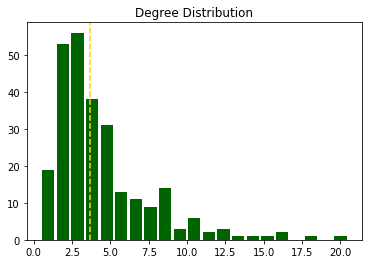

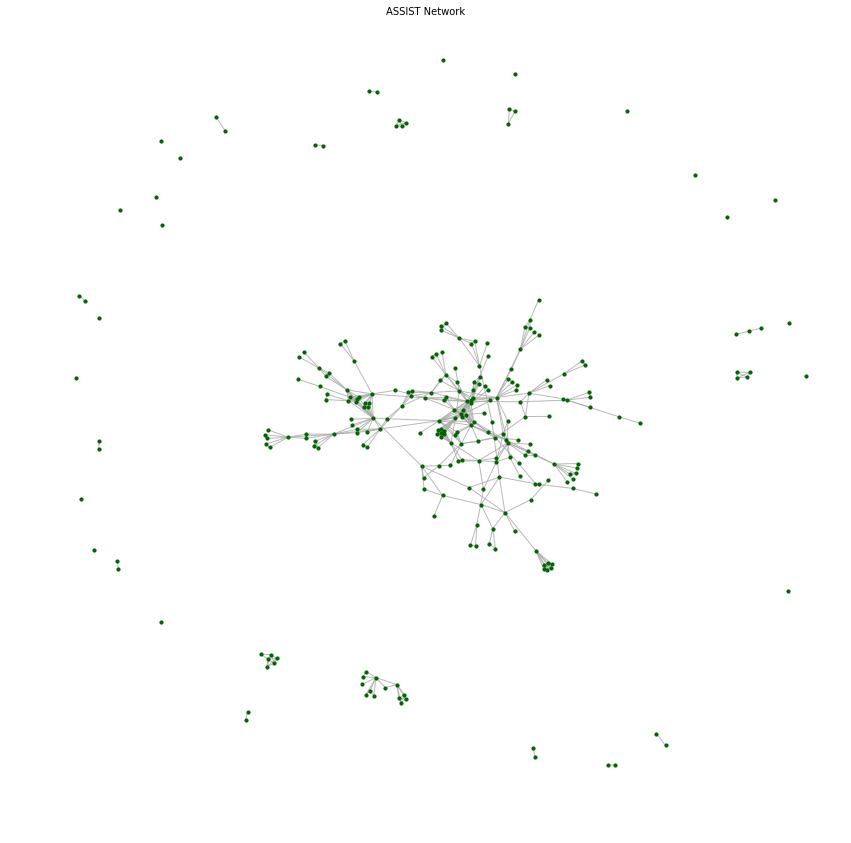

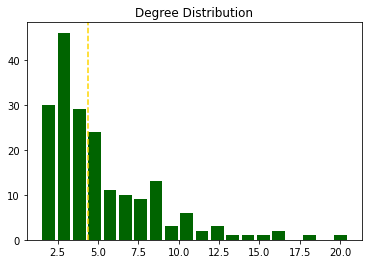

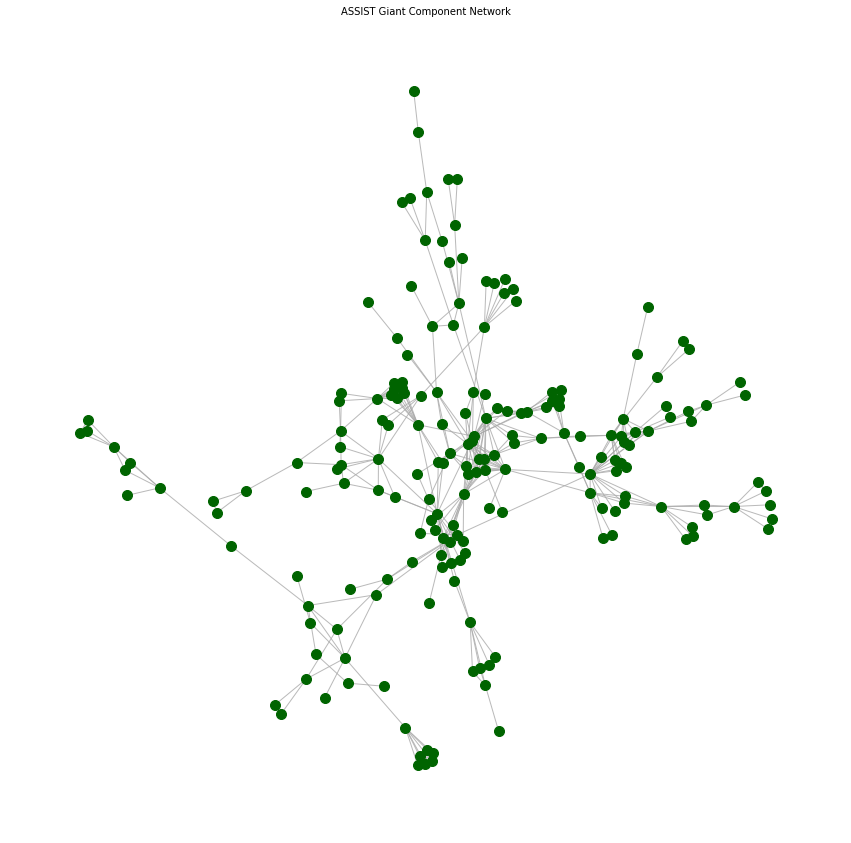

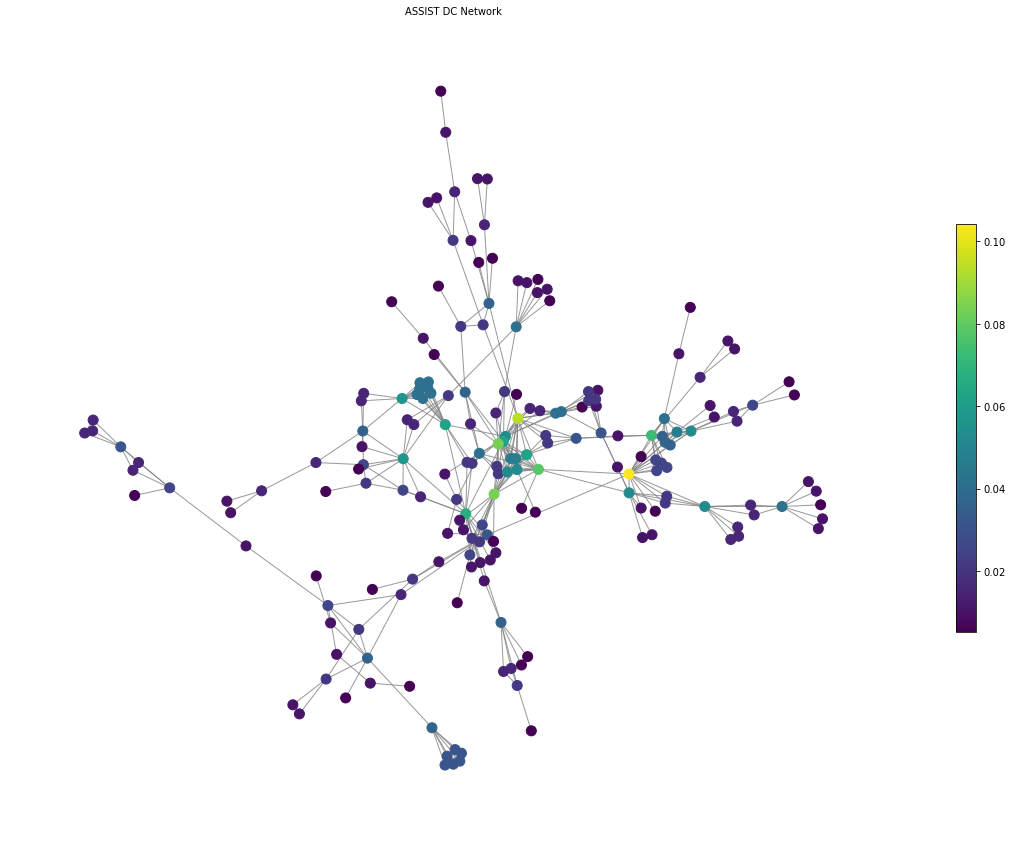

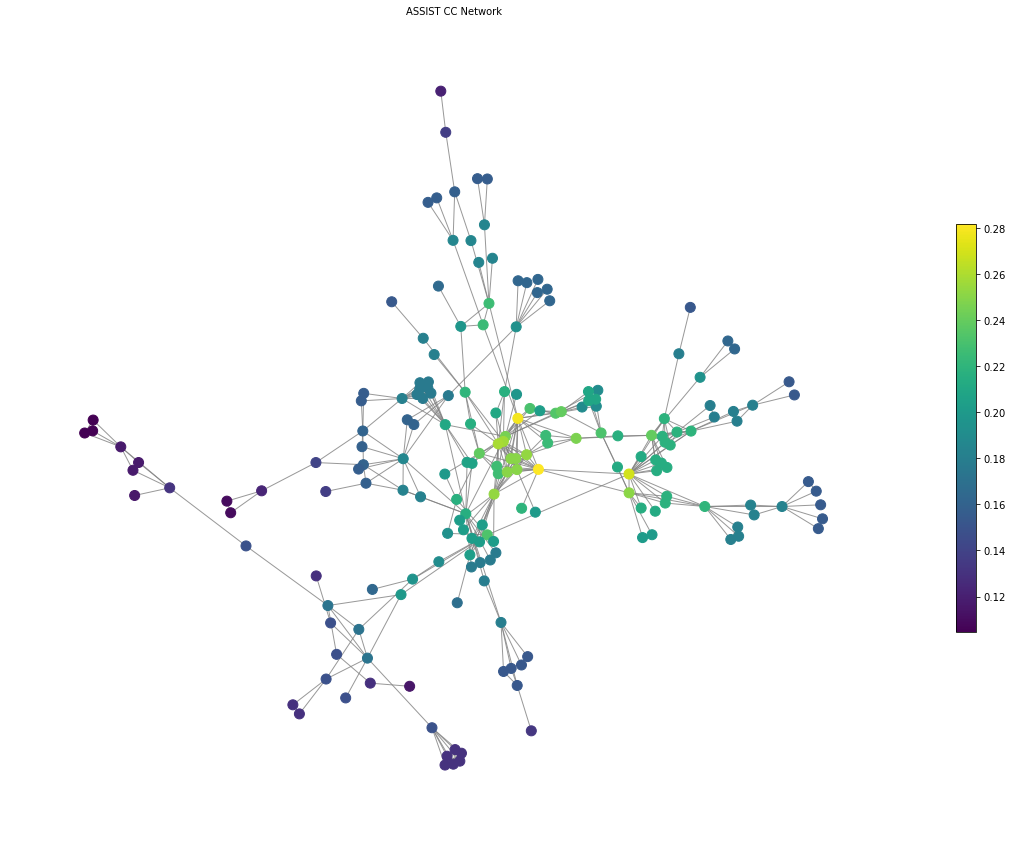

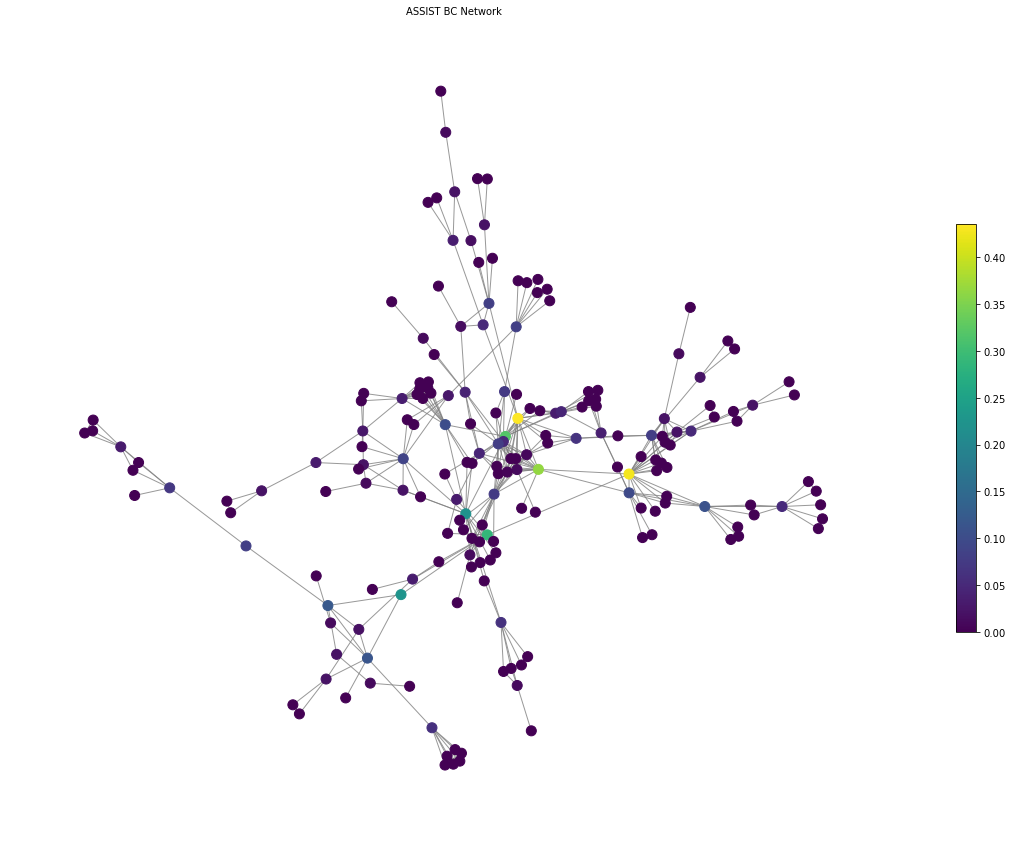

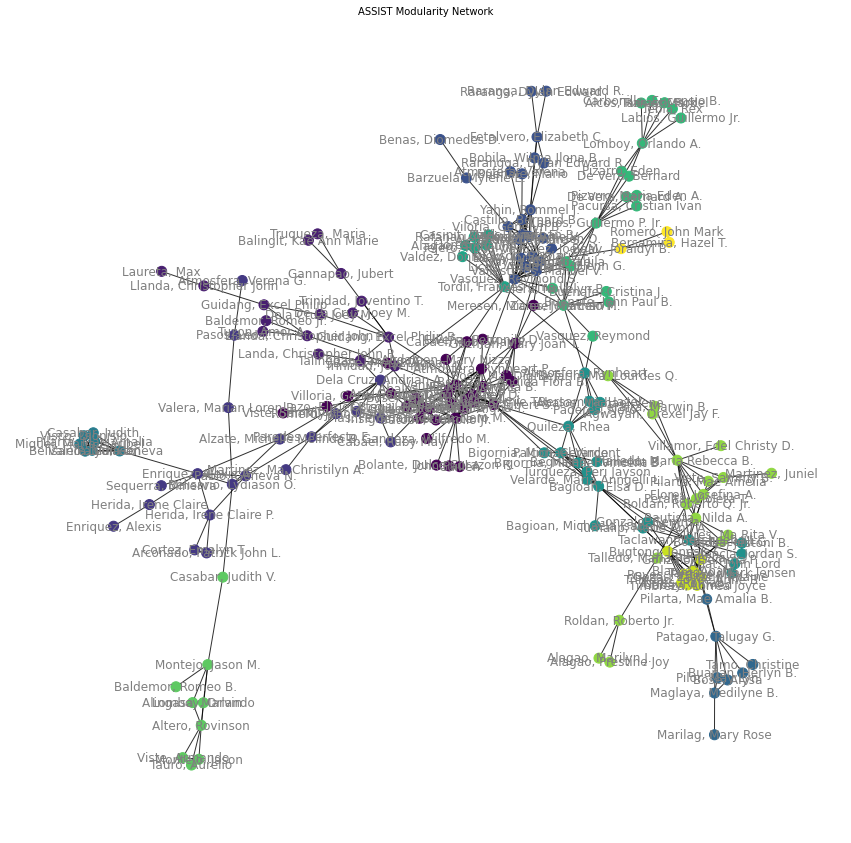

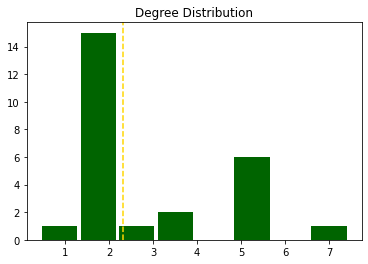

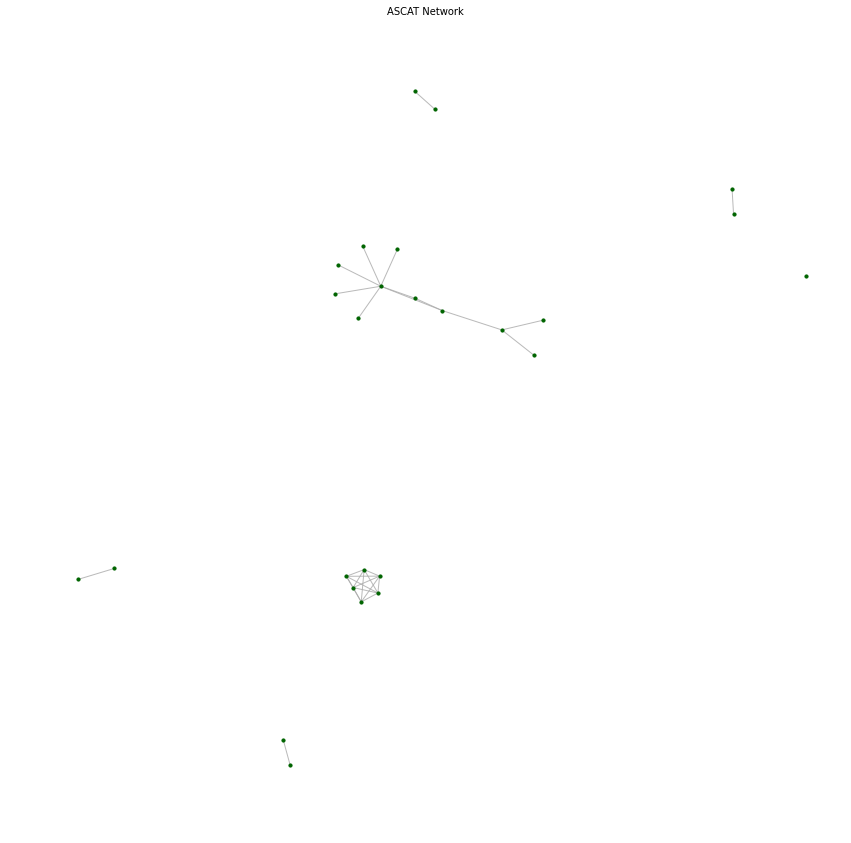

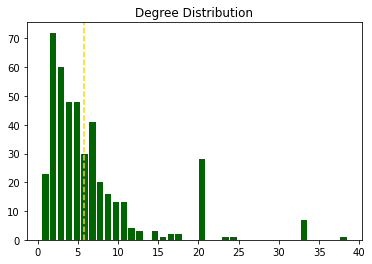

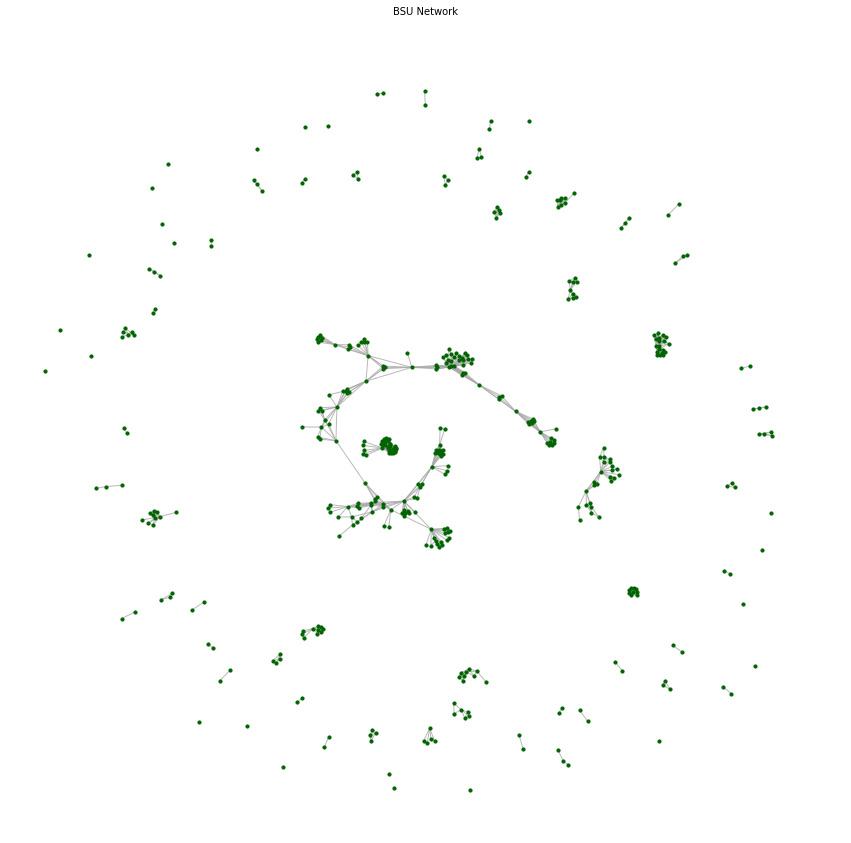

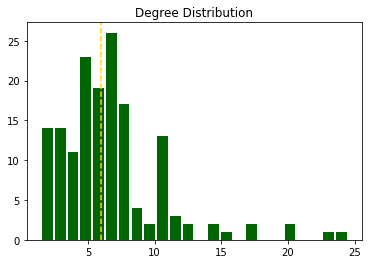

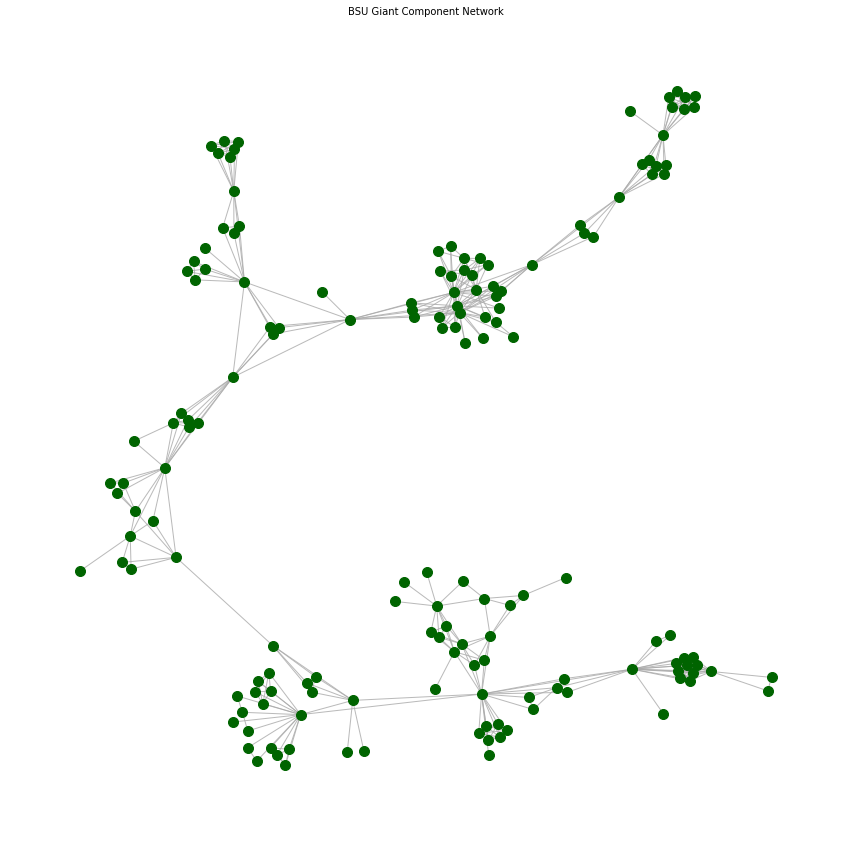

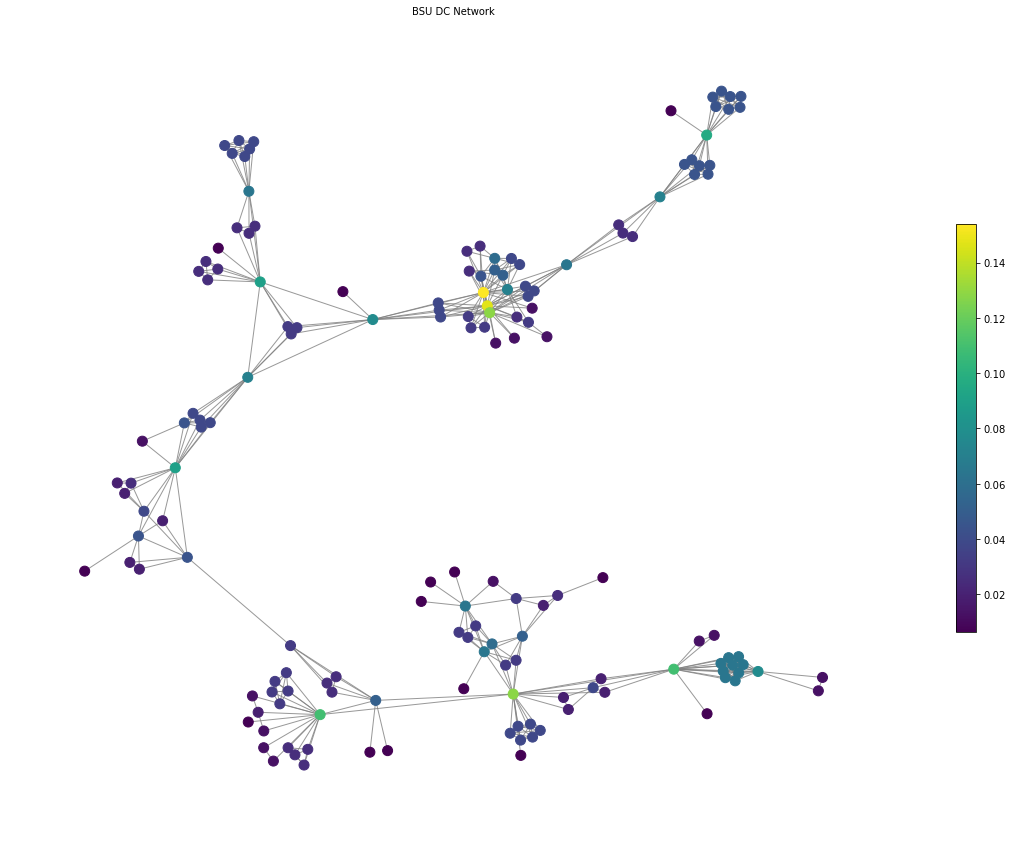

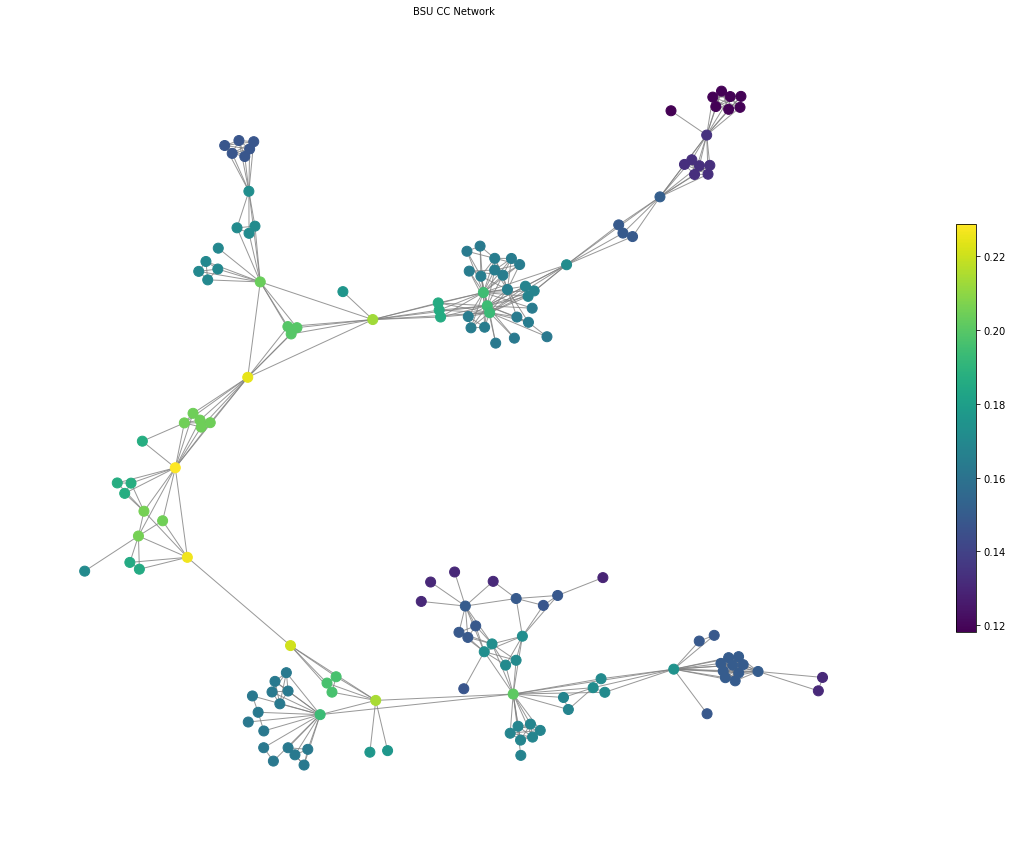

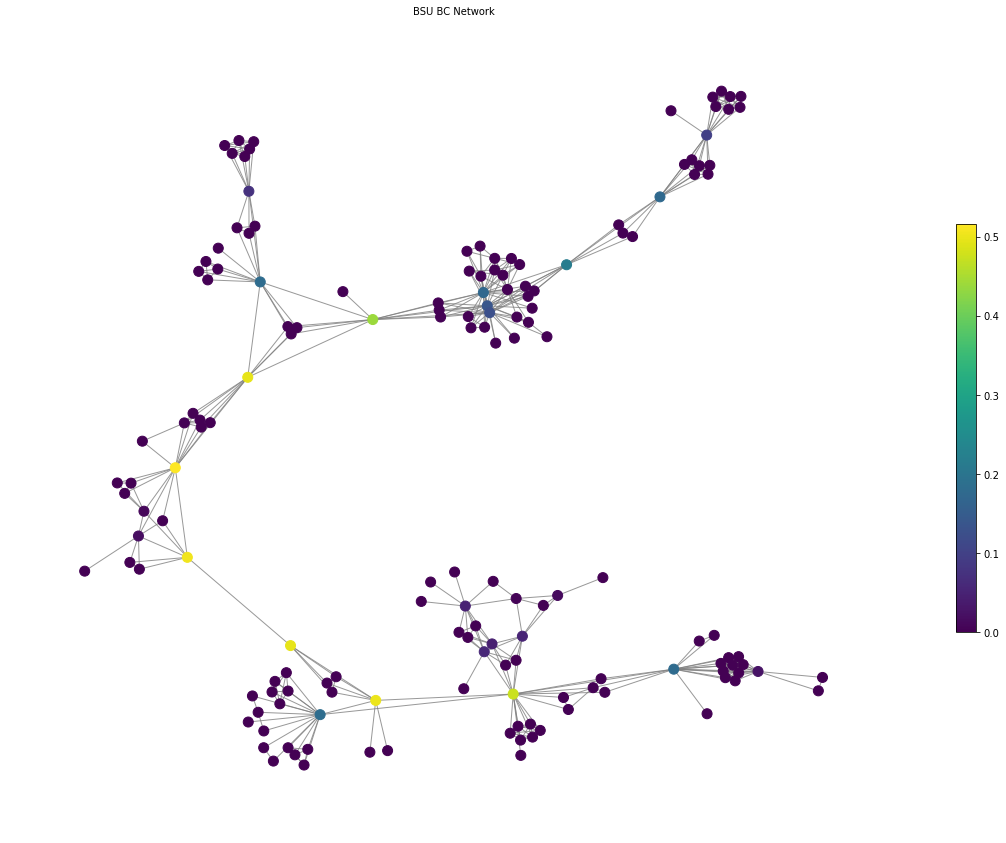

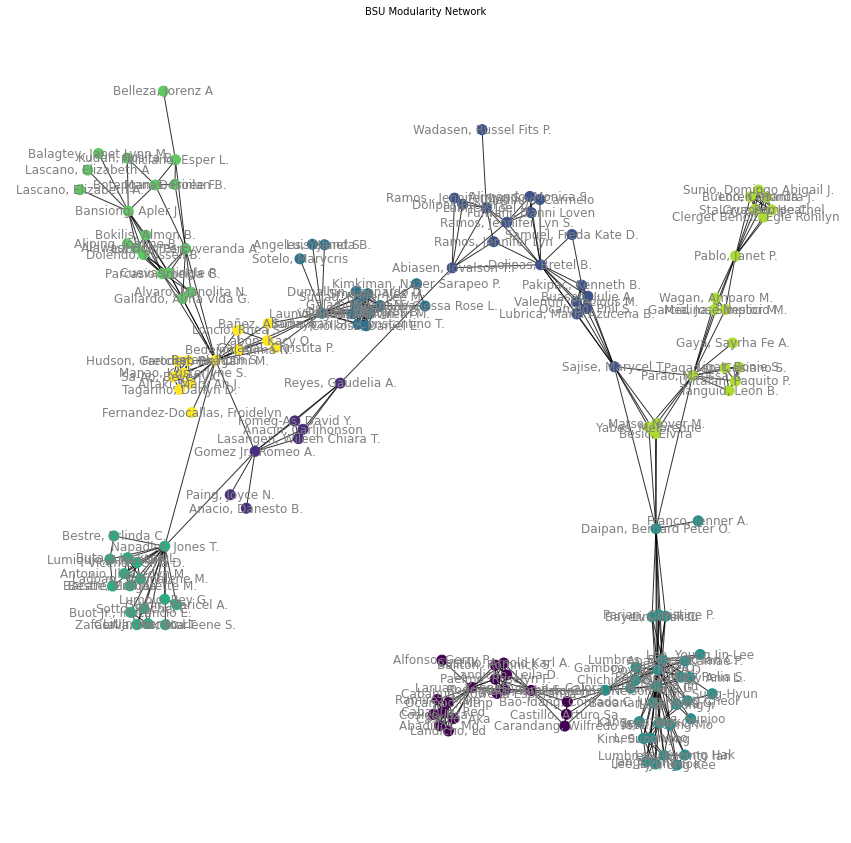

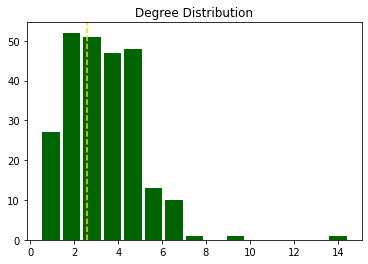

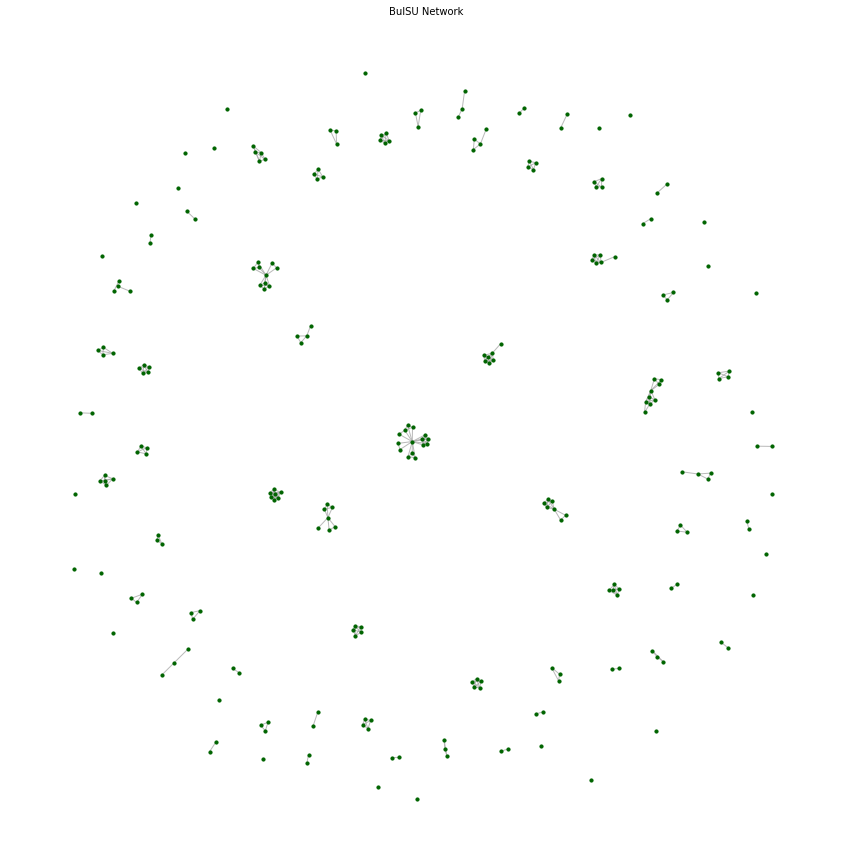

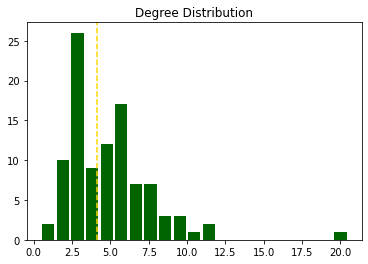

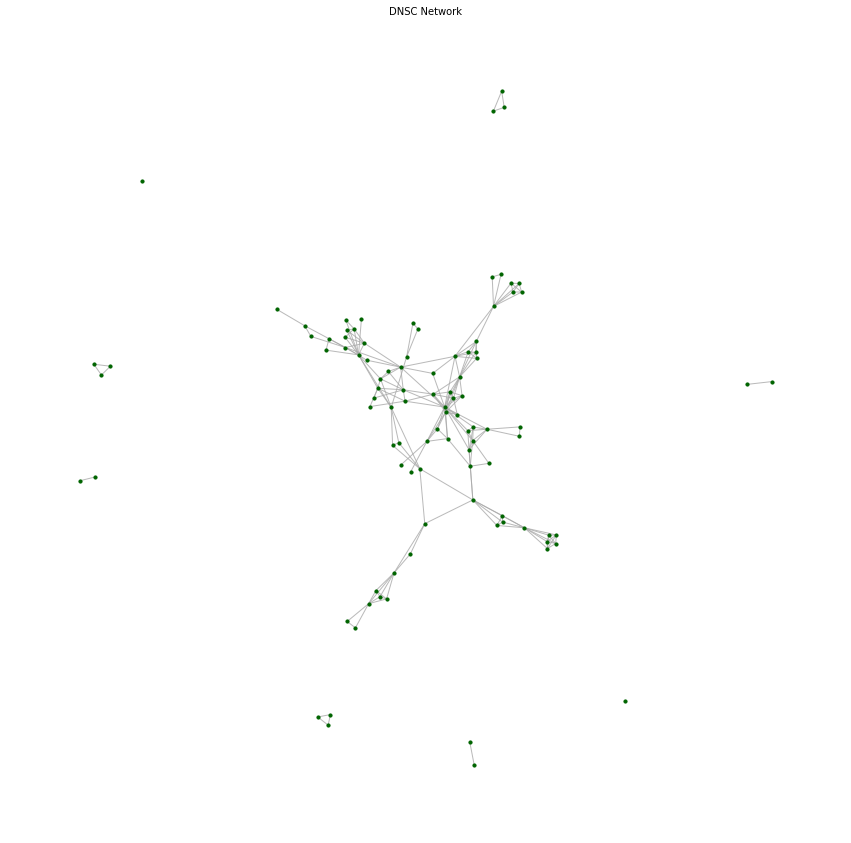

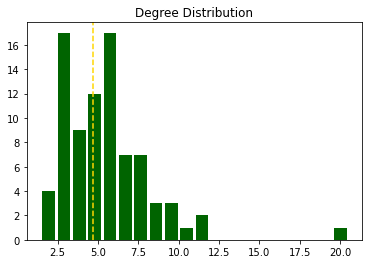

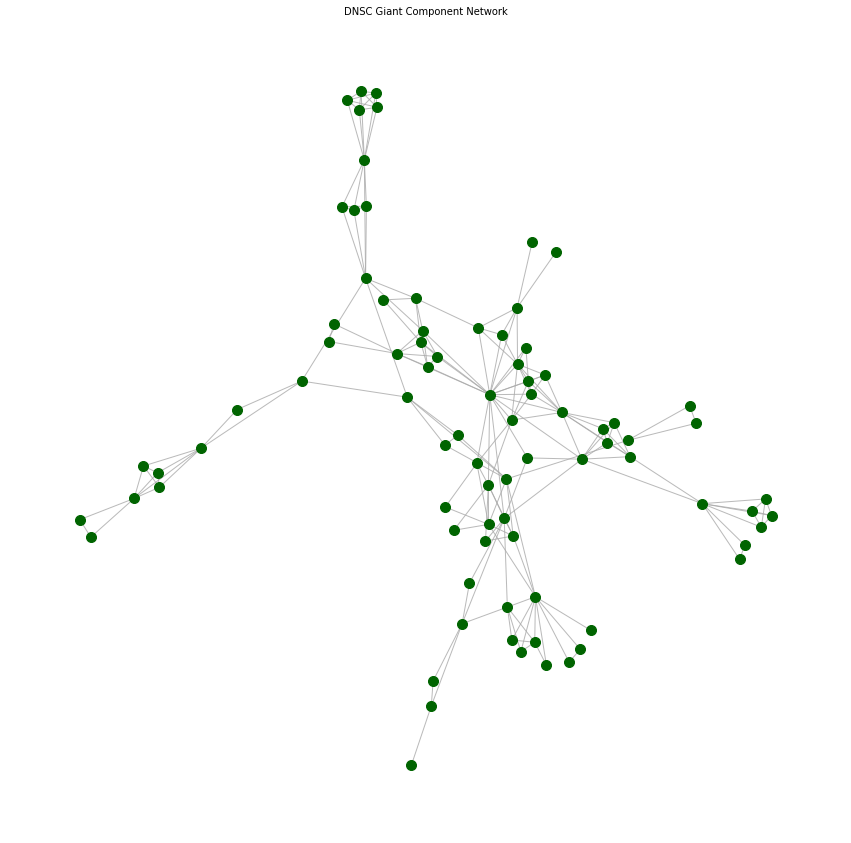

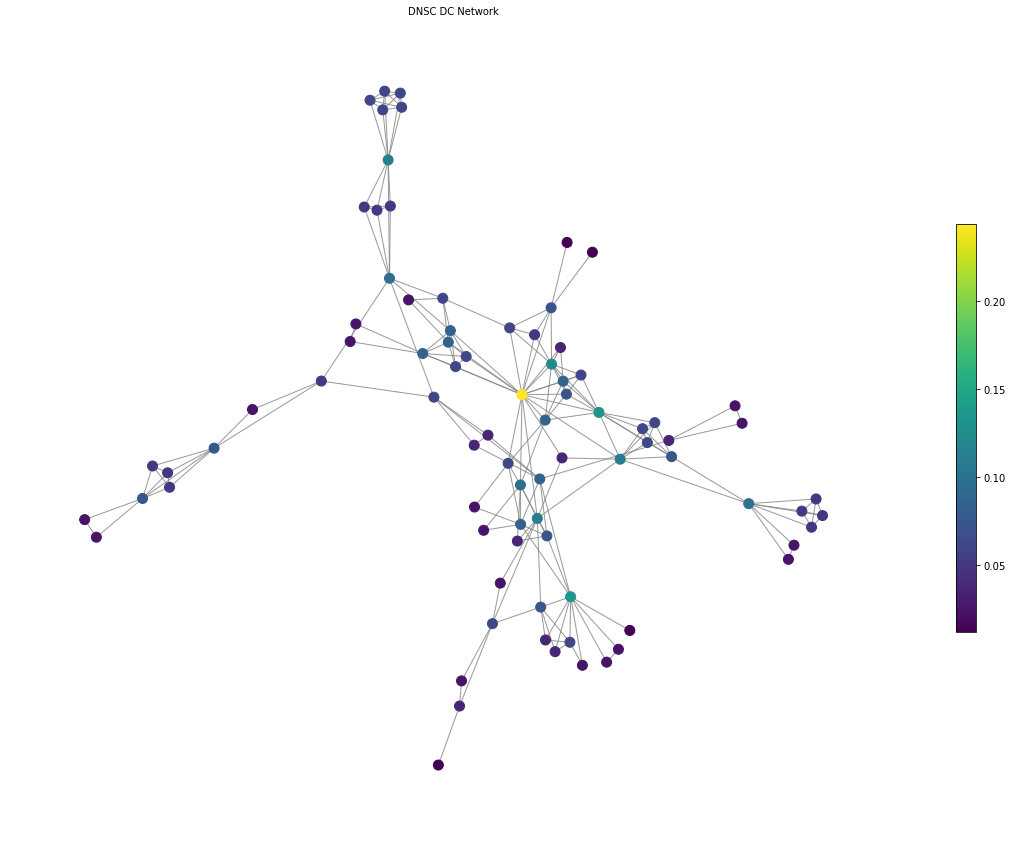

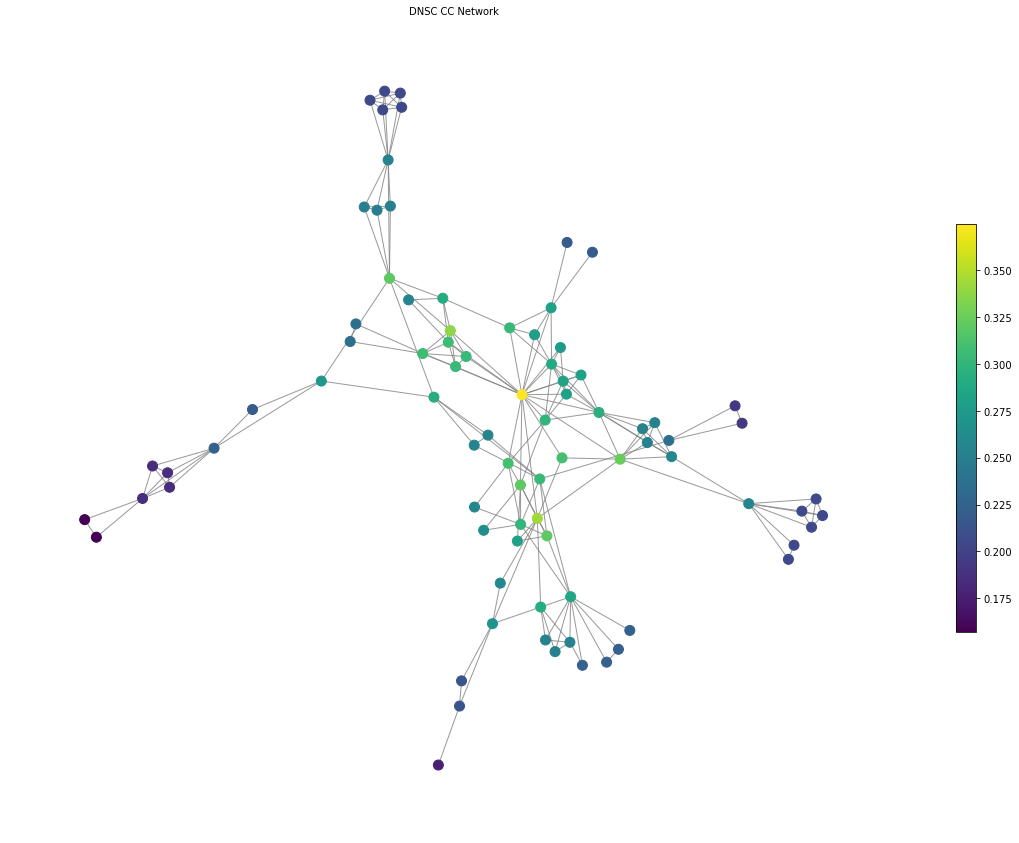

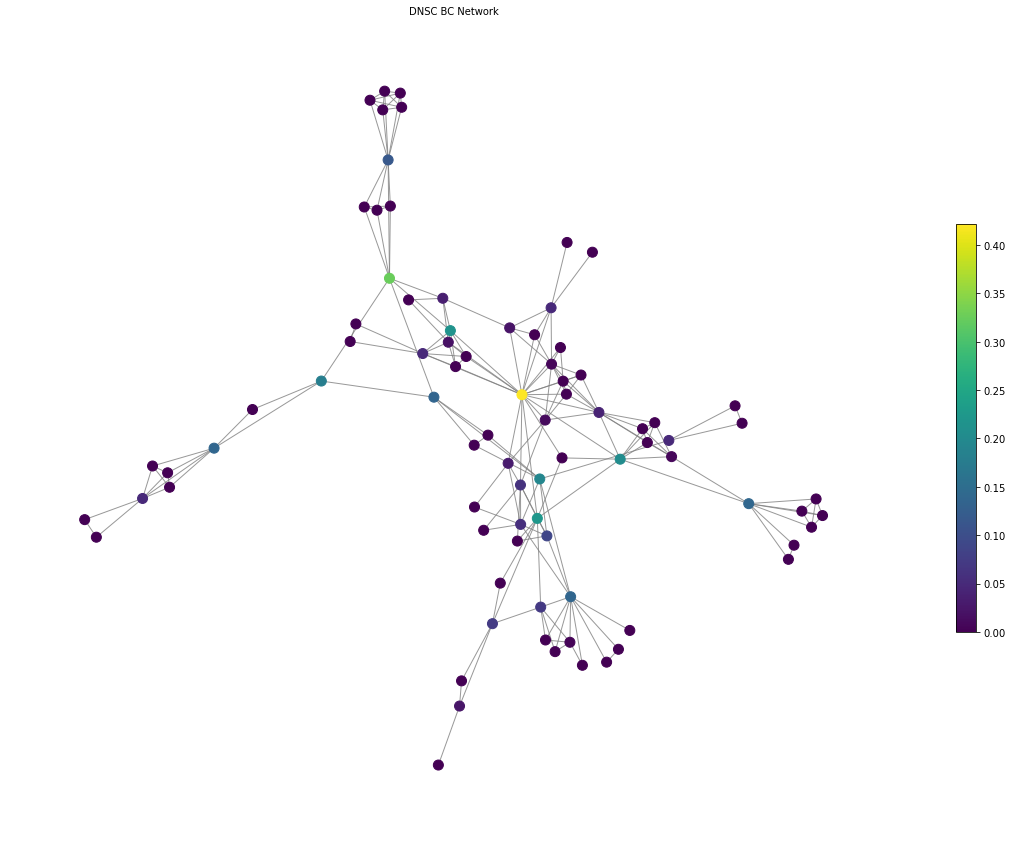

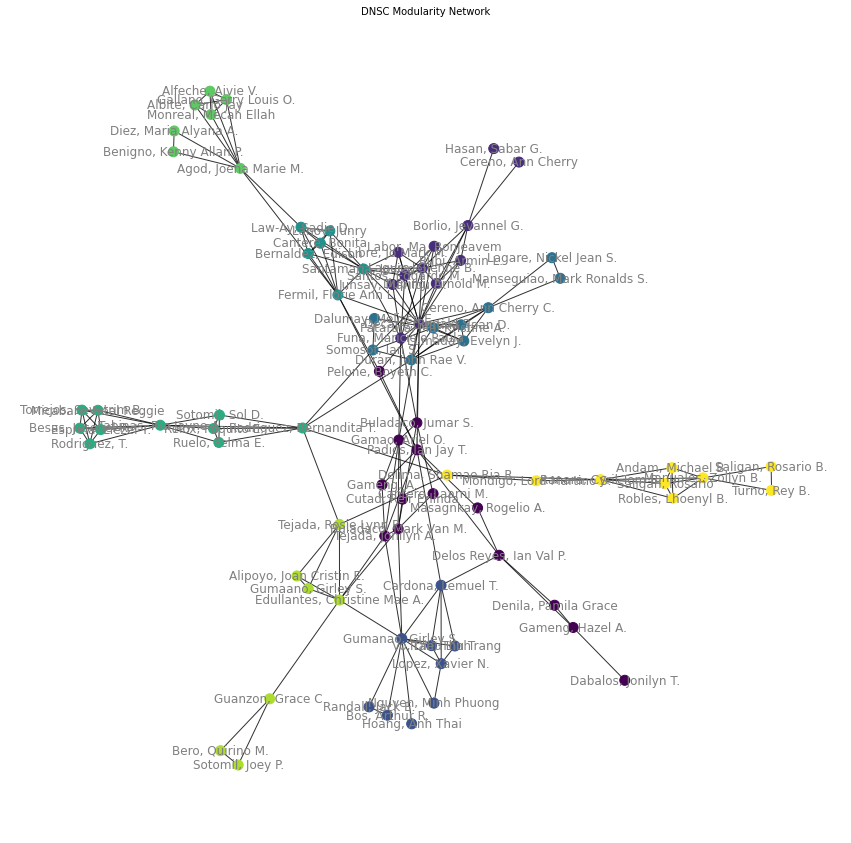

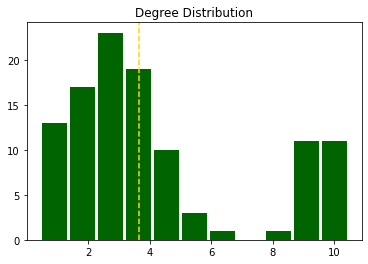

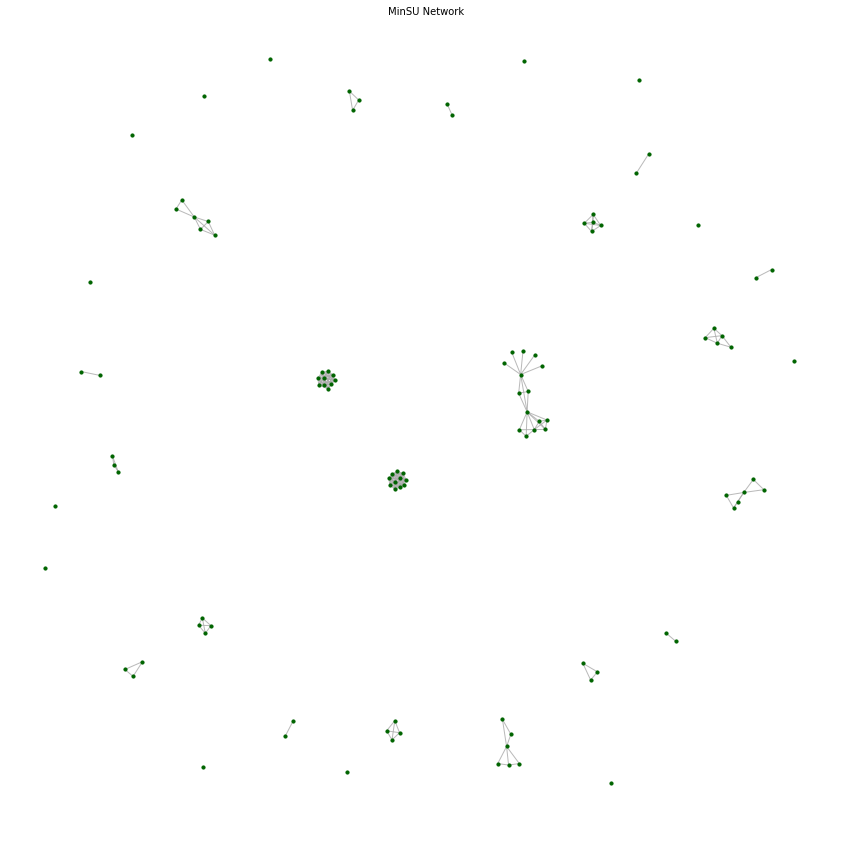

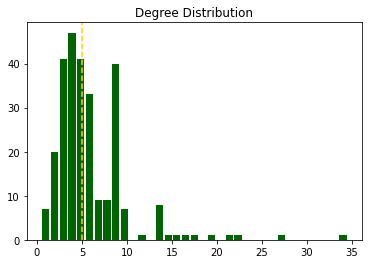

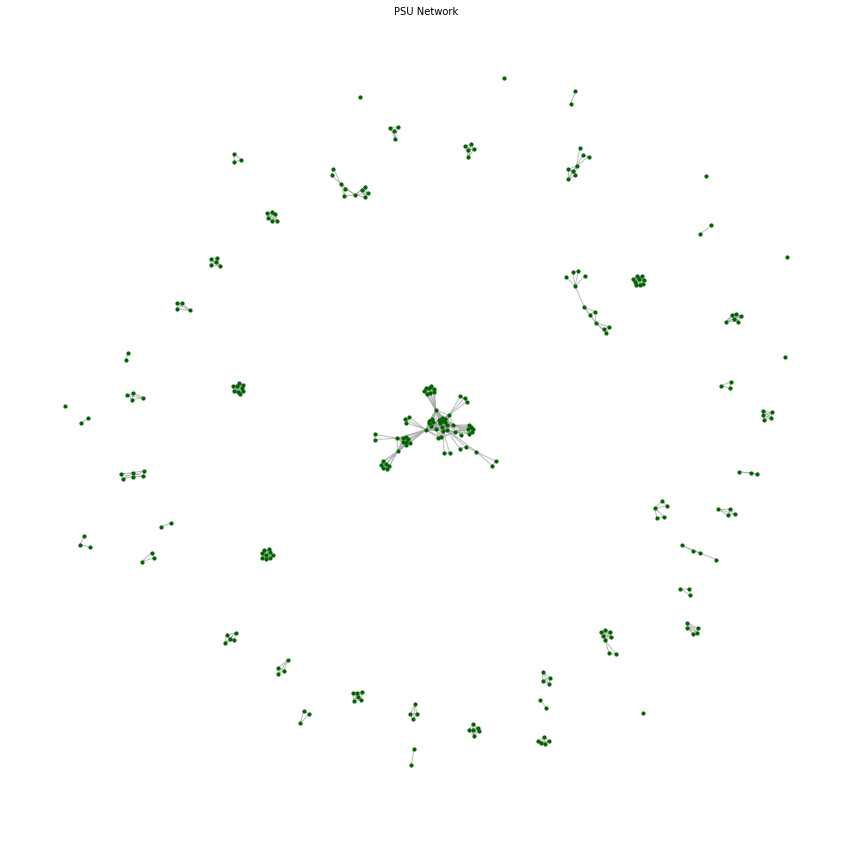

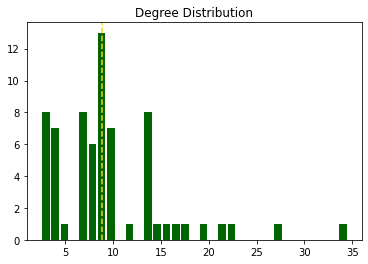

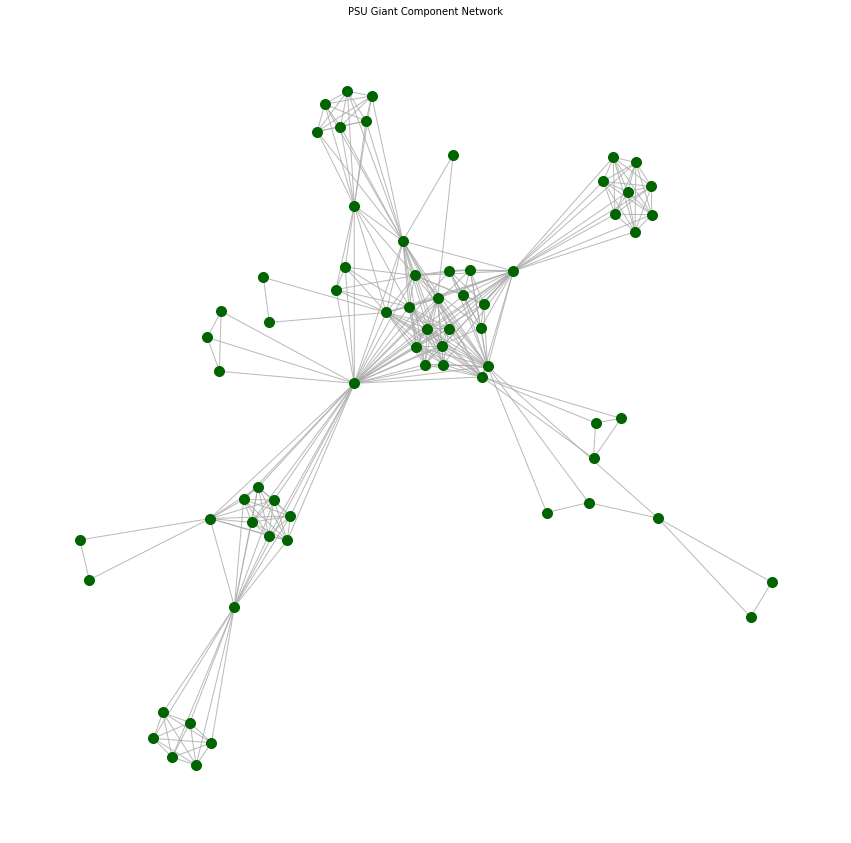

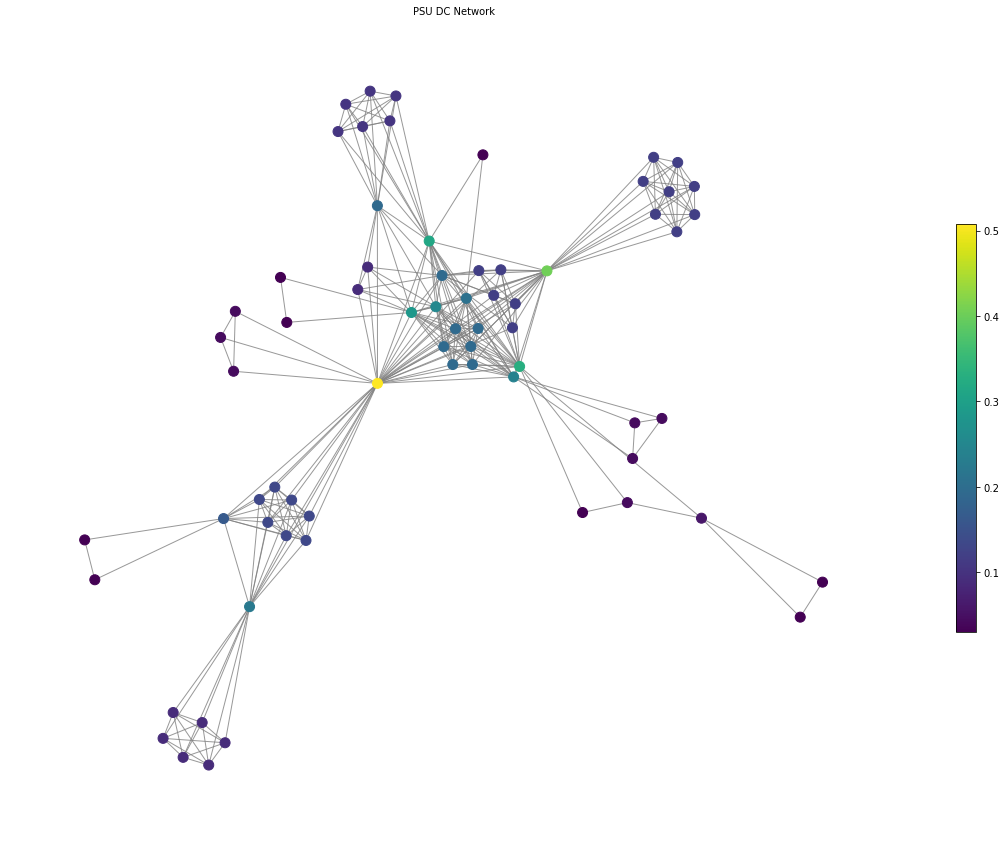

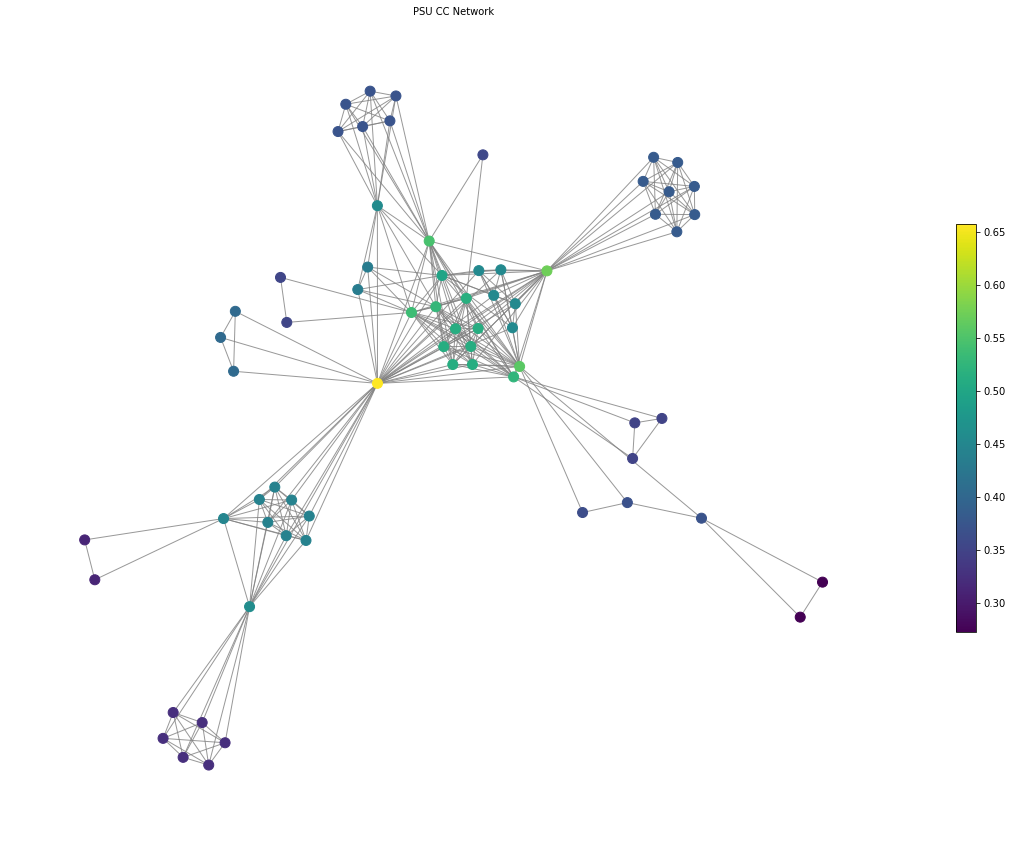

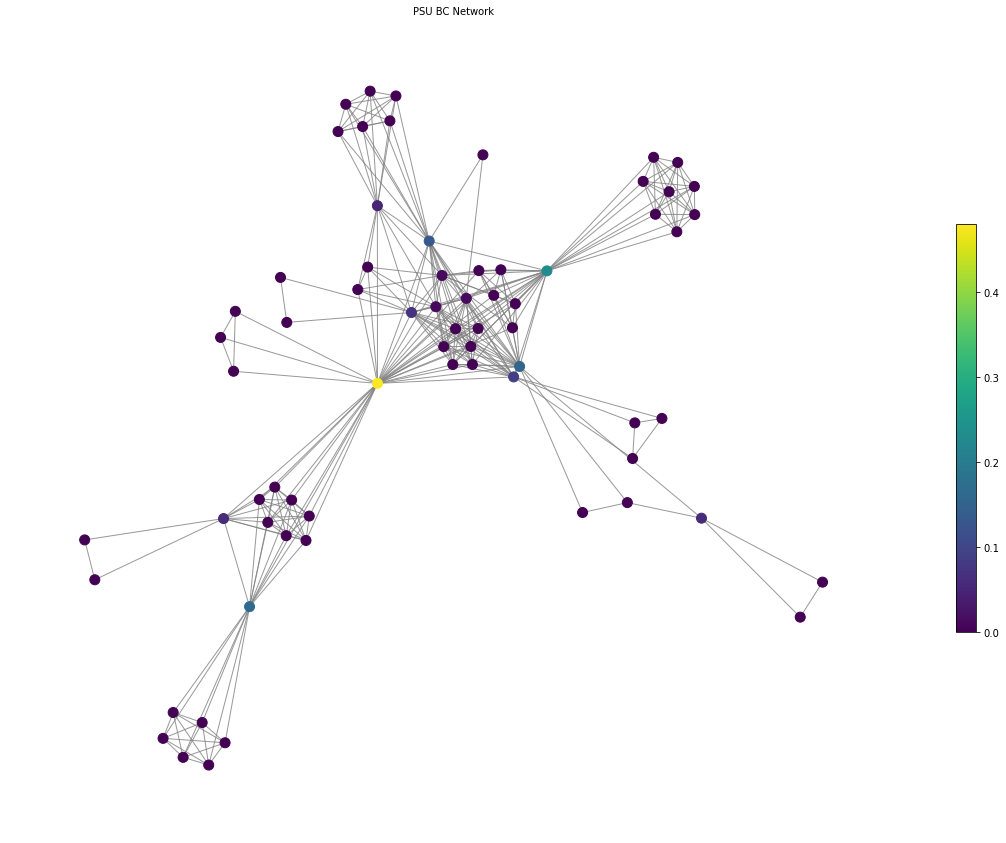

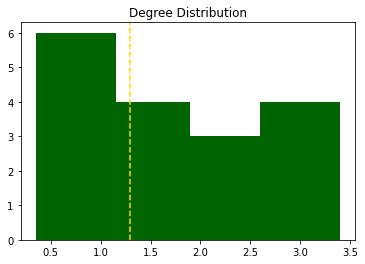

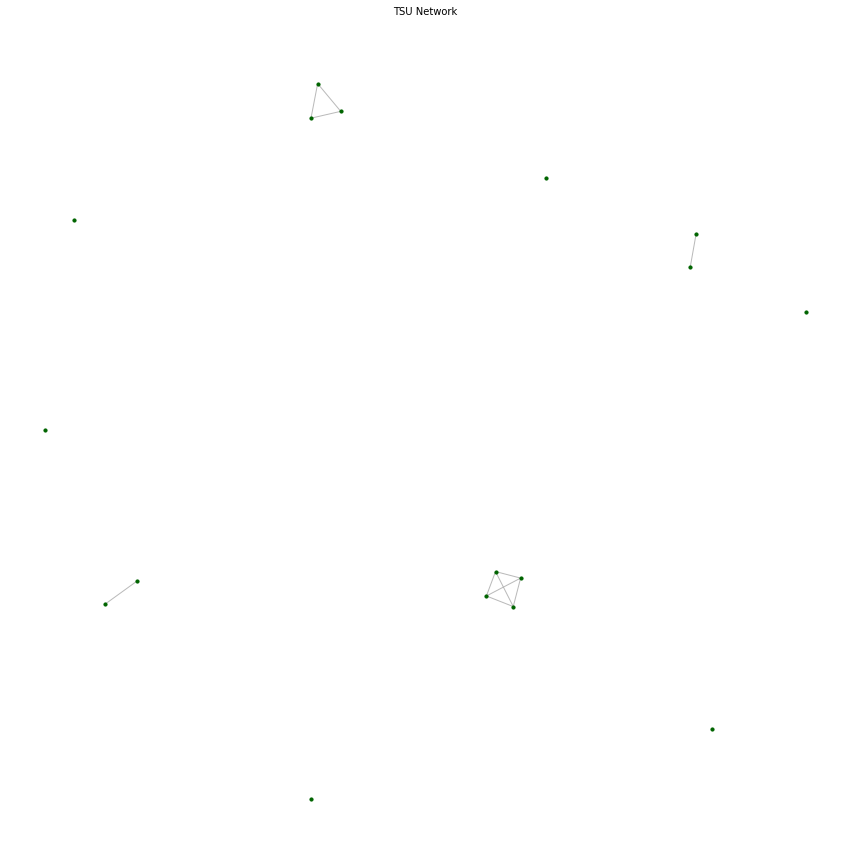

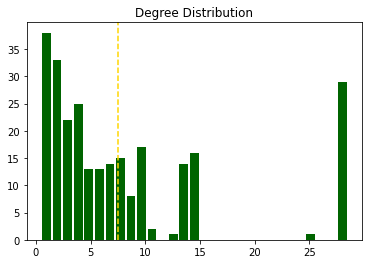

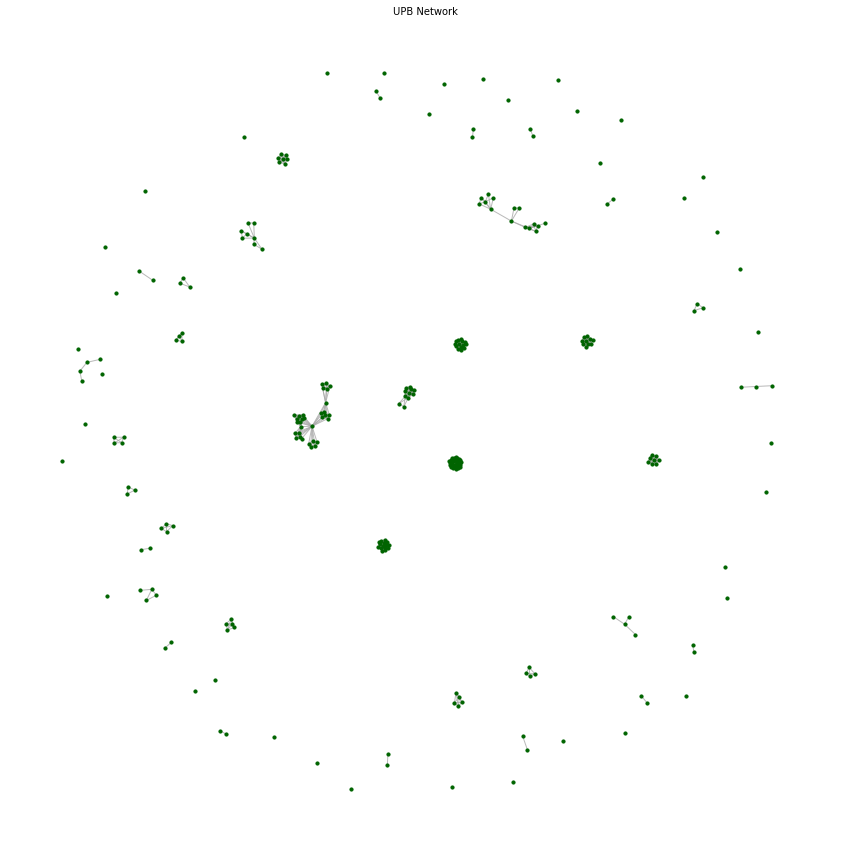

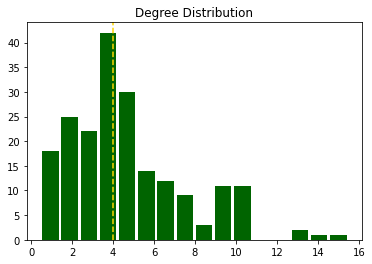

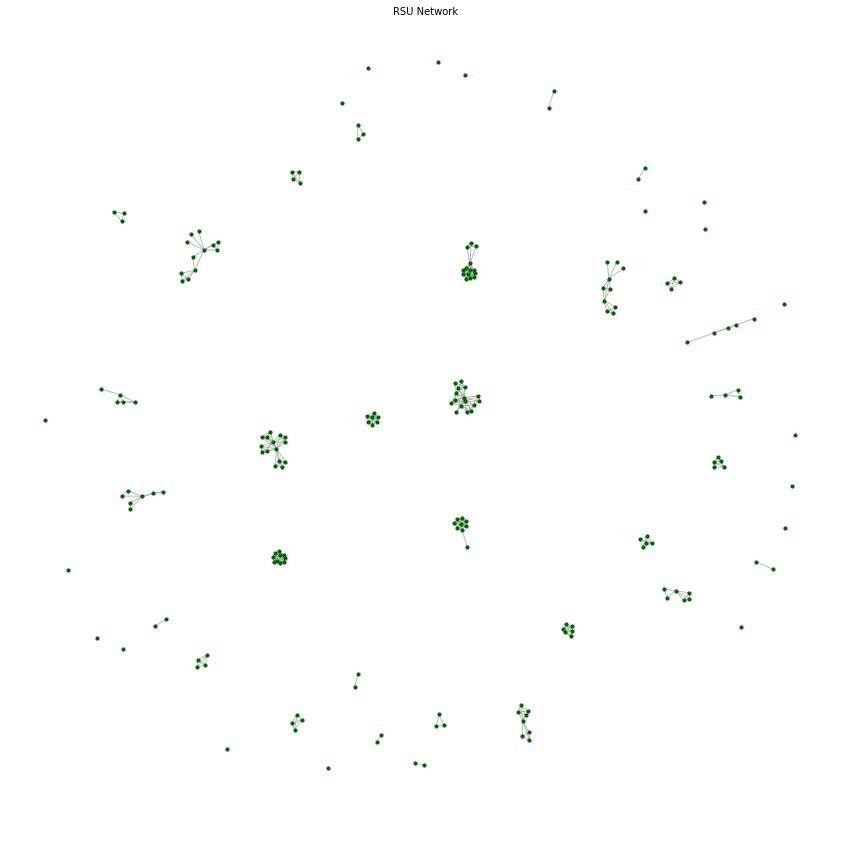

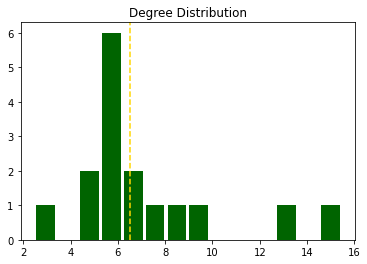

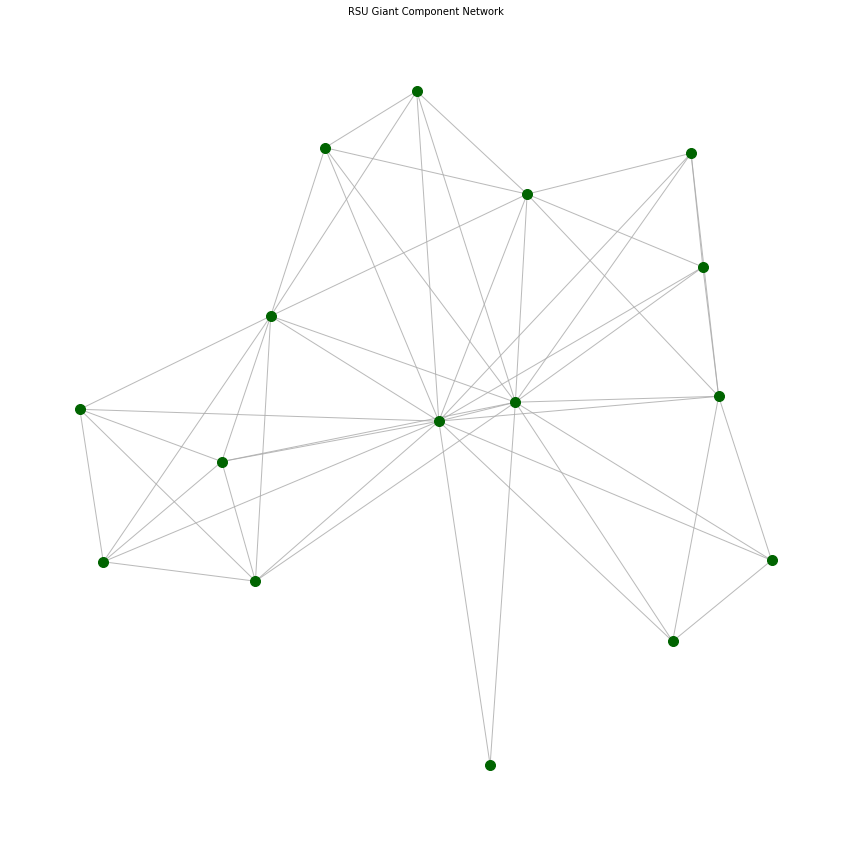

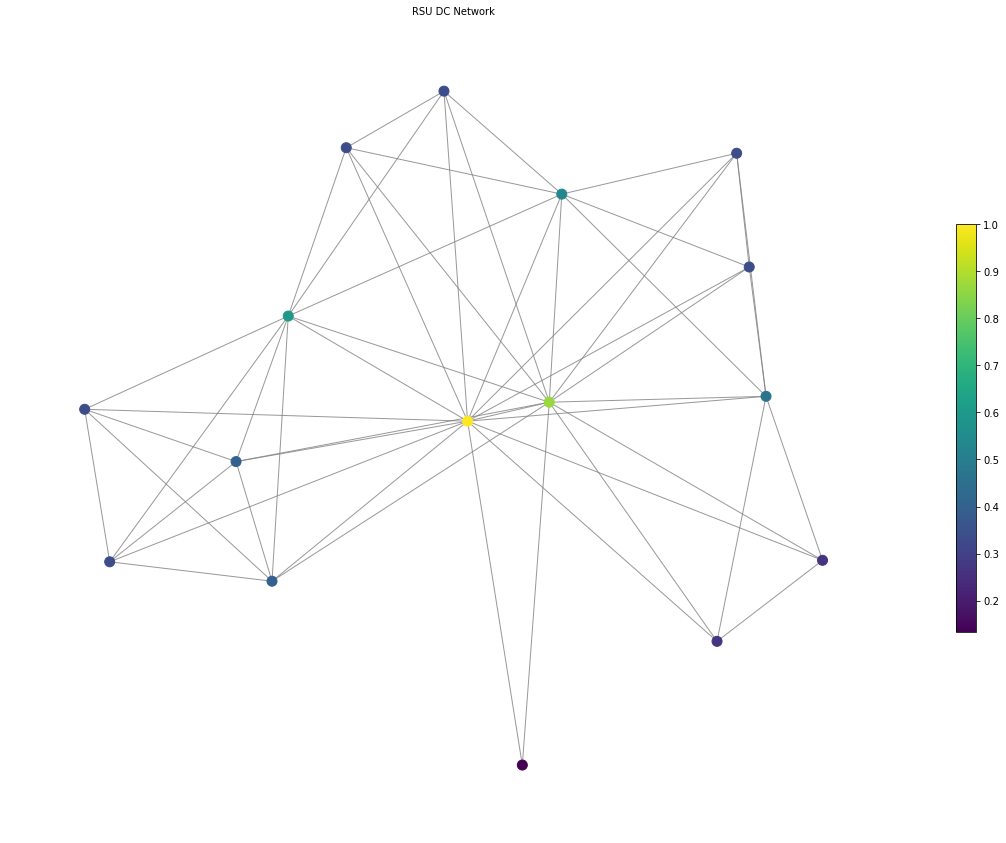

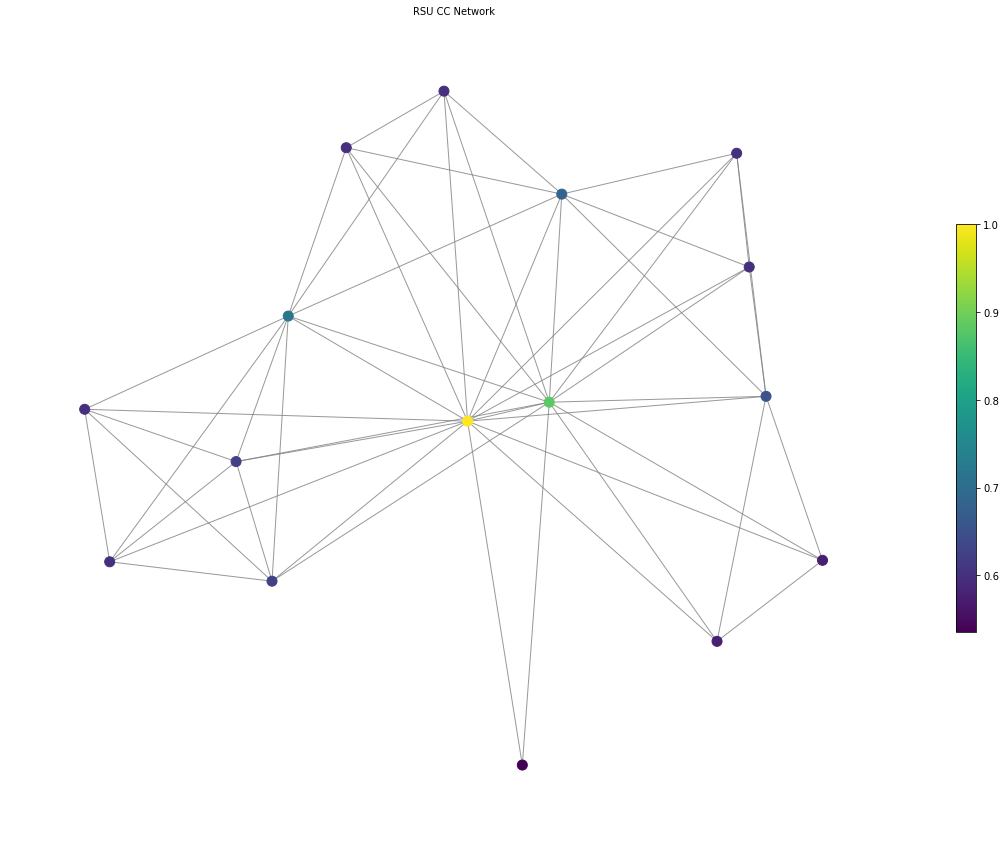

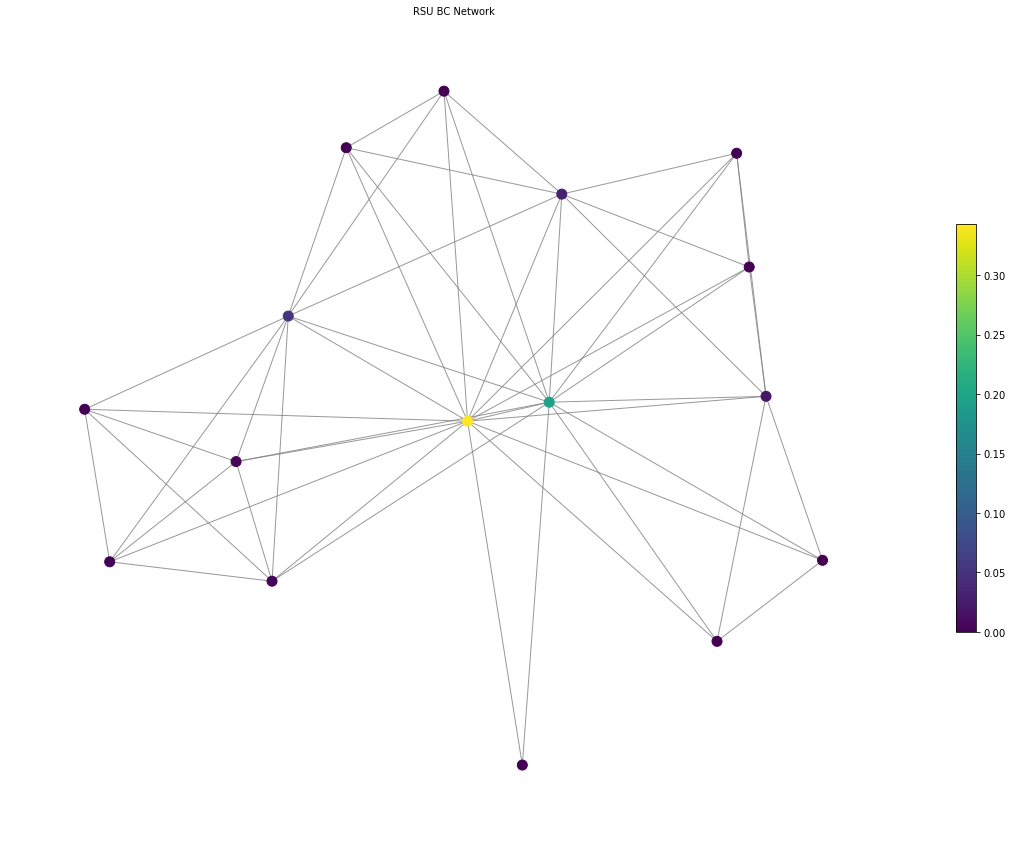

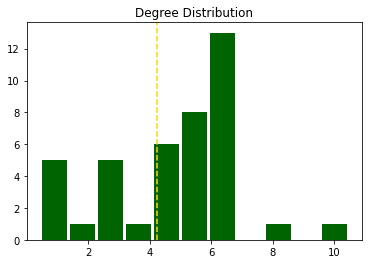

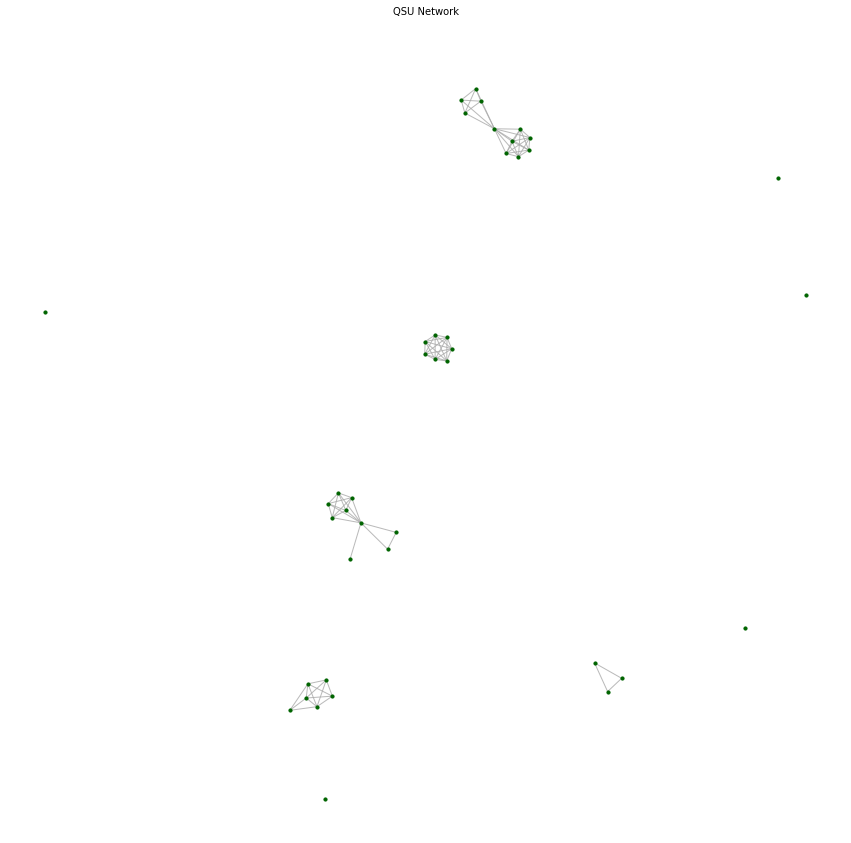

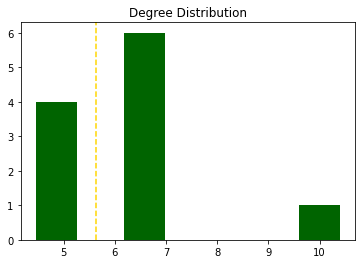

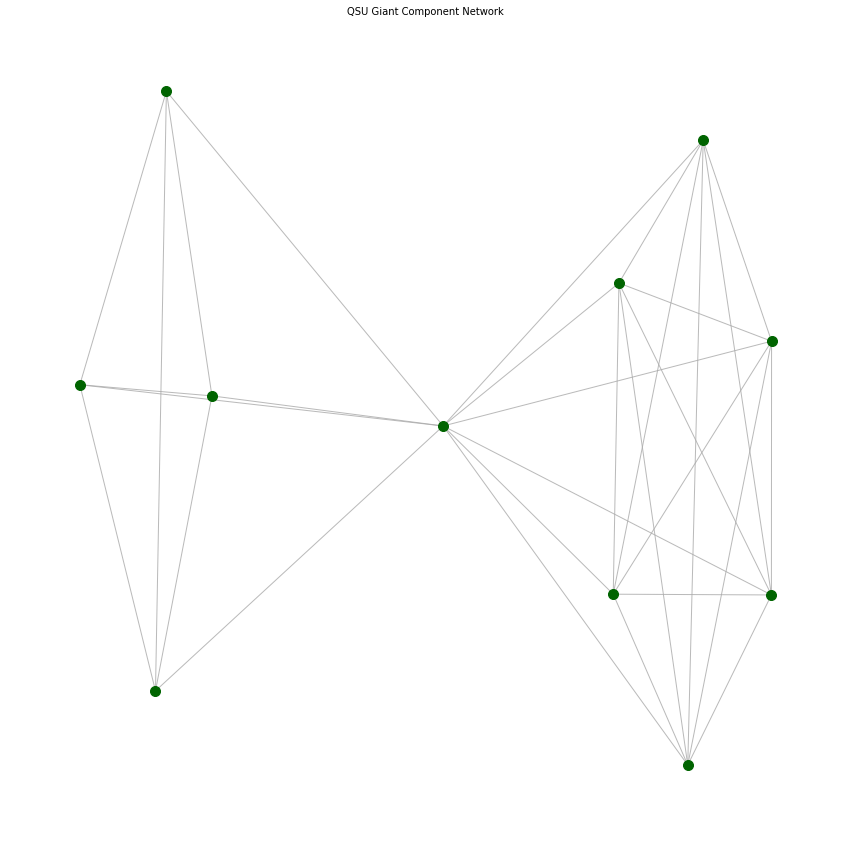

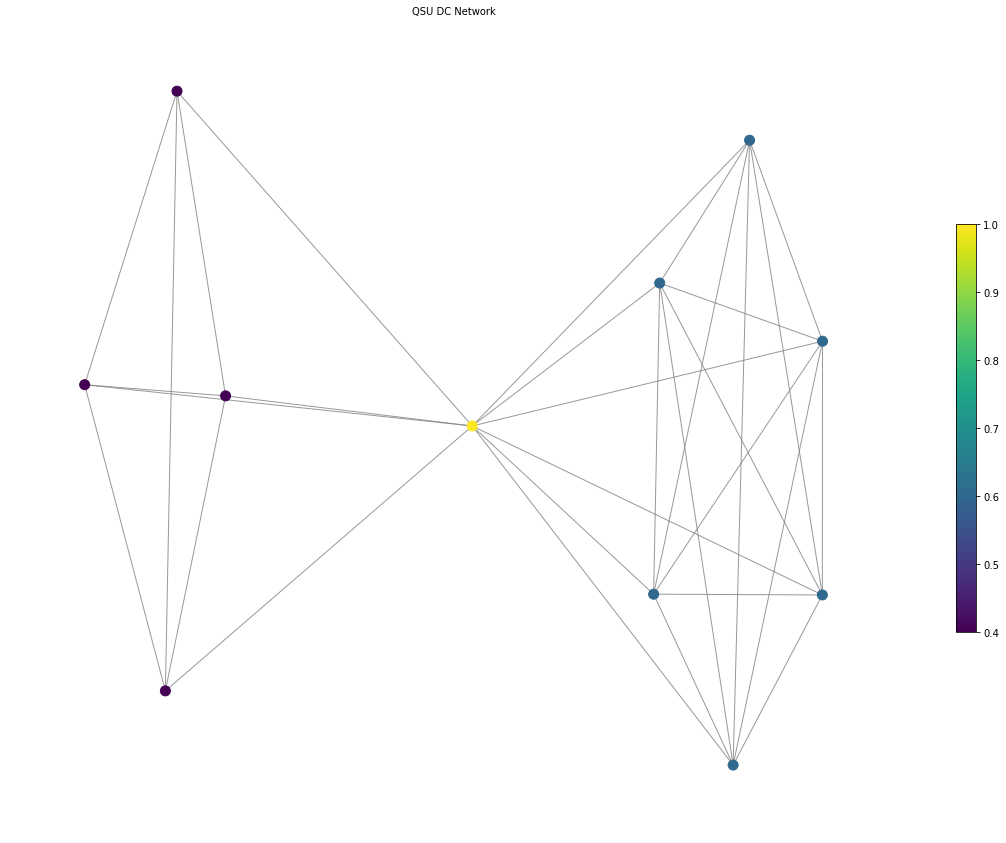

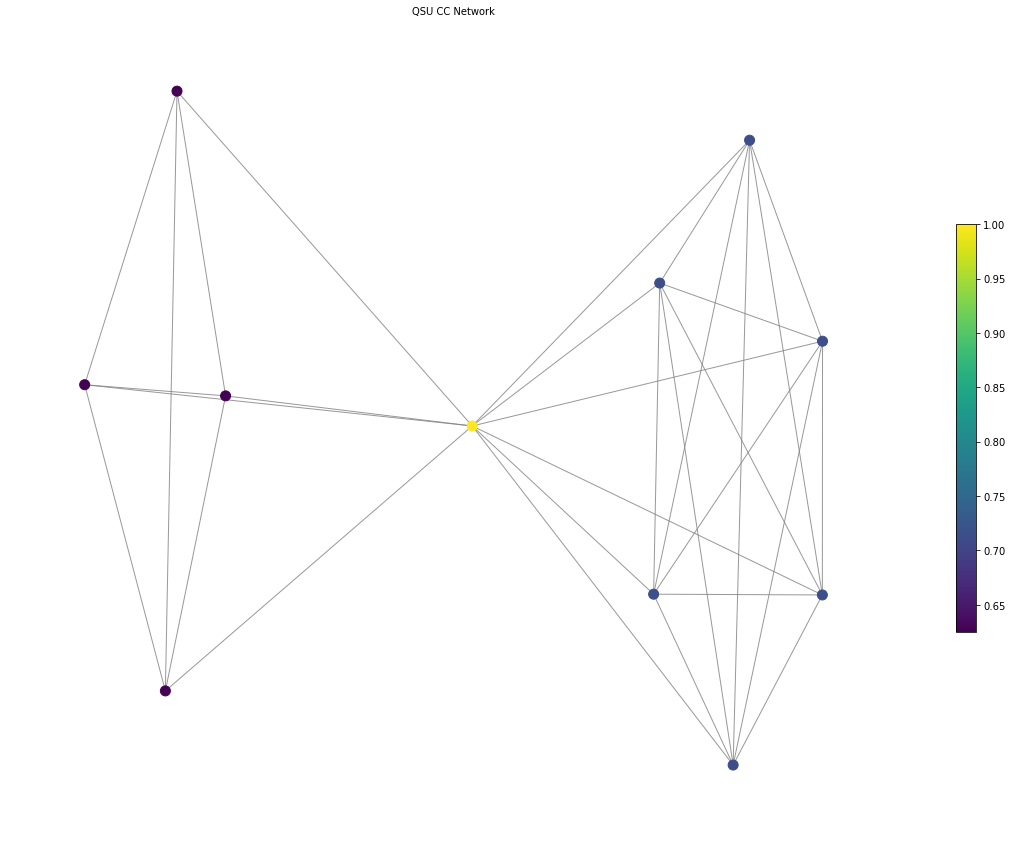

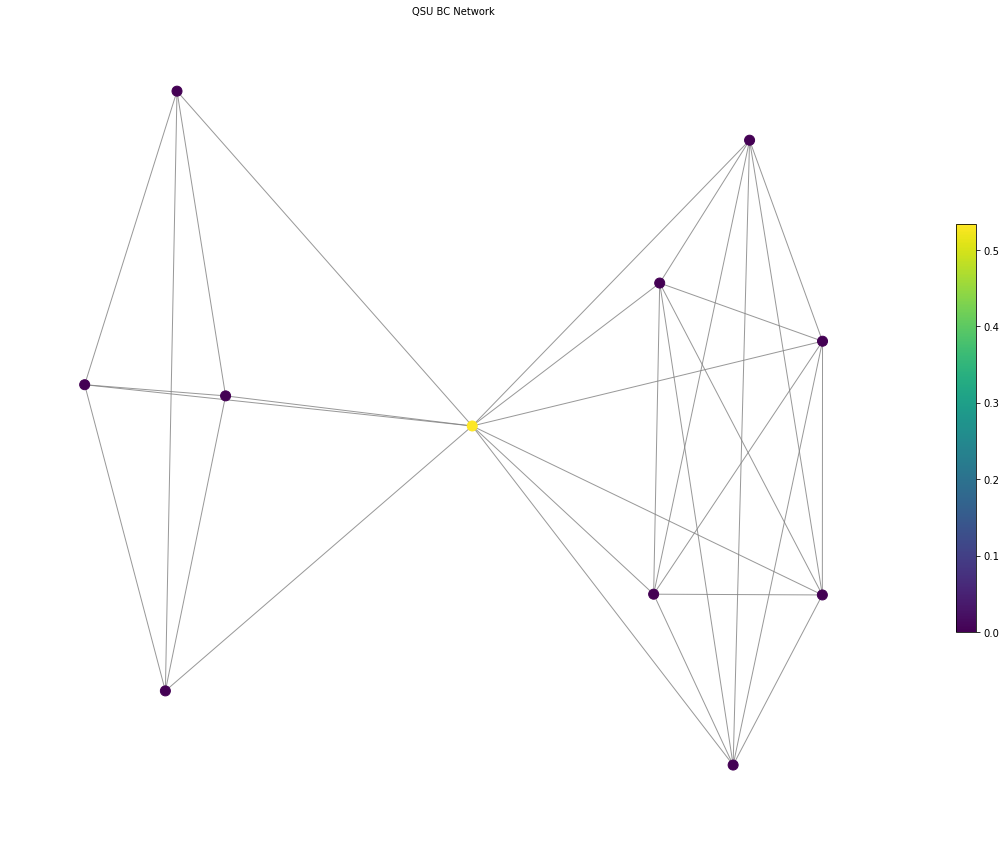

In [25]:
#dont run if not needed
#outputs and saves images of plots

for suc in suc_list:
    sucs = df_rp[df_rp['University (Full Name)'] == suc[0]]
    suc_authors = sucs['Author'].copy().str.split(';')

    edges, nodes = take_edges(suc_authors)

    network = nx.Graph()
    
    for i in edges:
        network.add_edge(i[0], i[1])
    
    for i in nodes:
        network.add_node(i)
    
    print(suc[0])
    
    network_plots(network, school=suc[1])

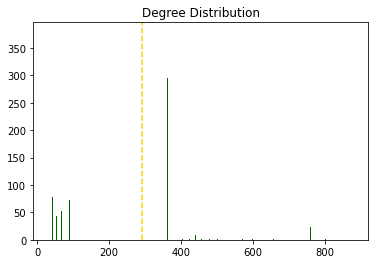

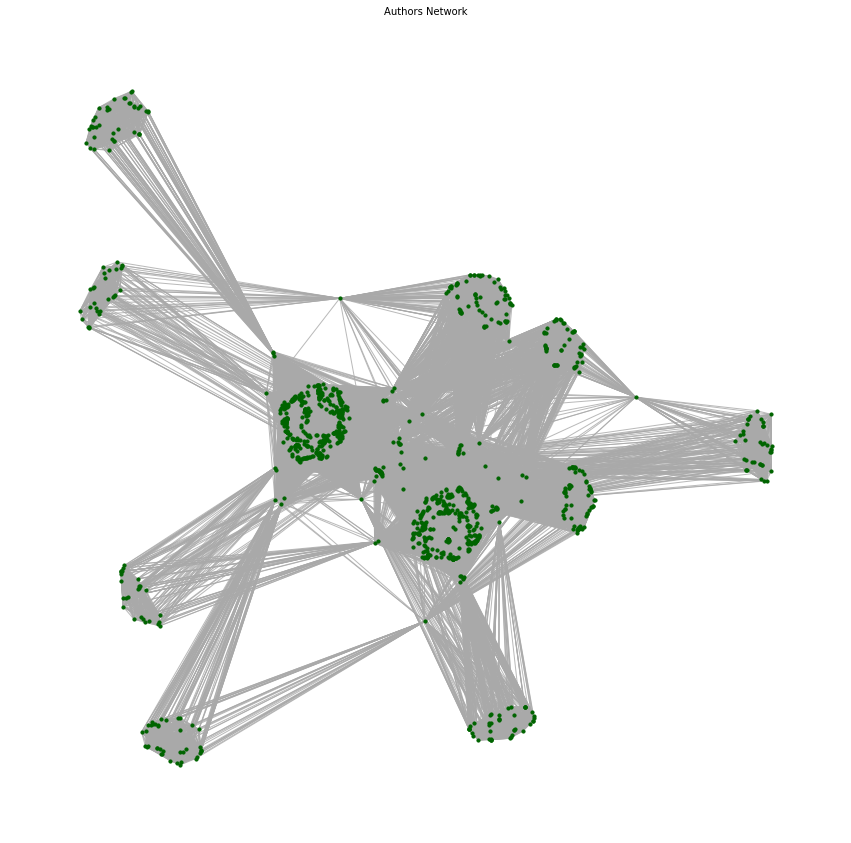

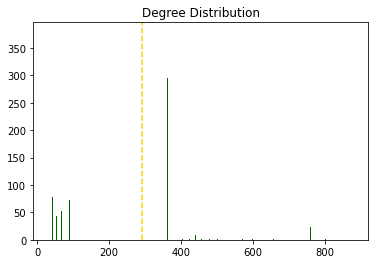

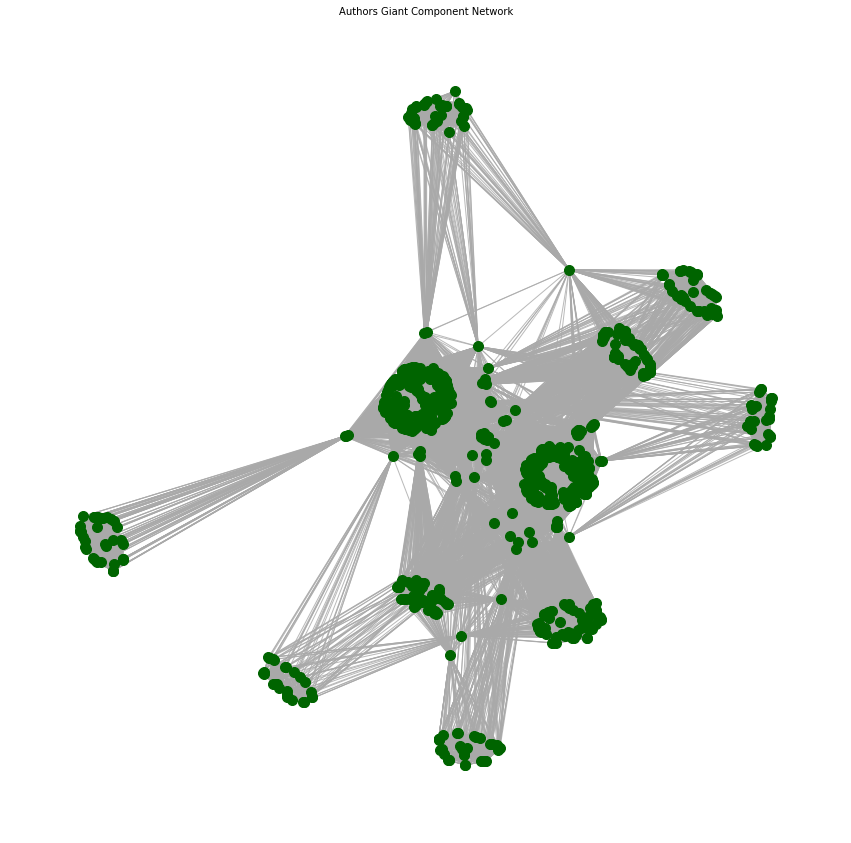

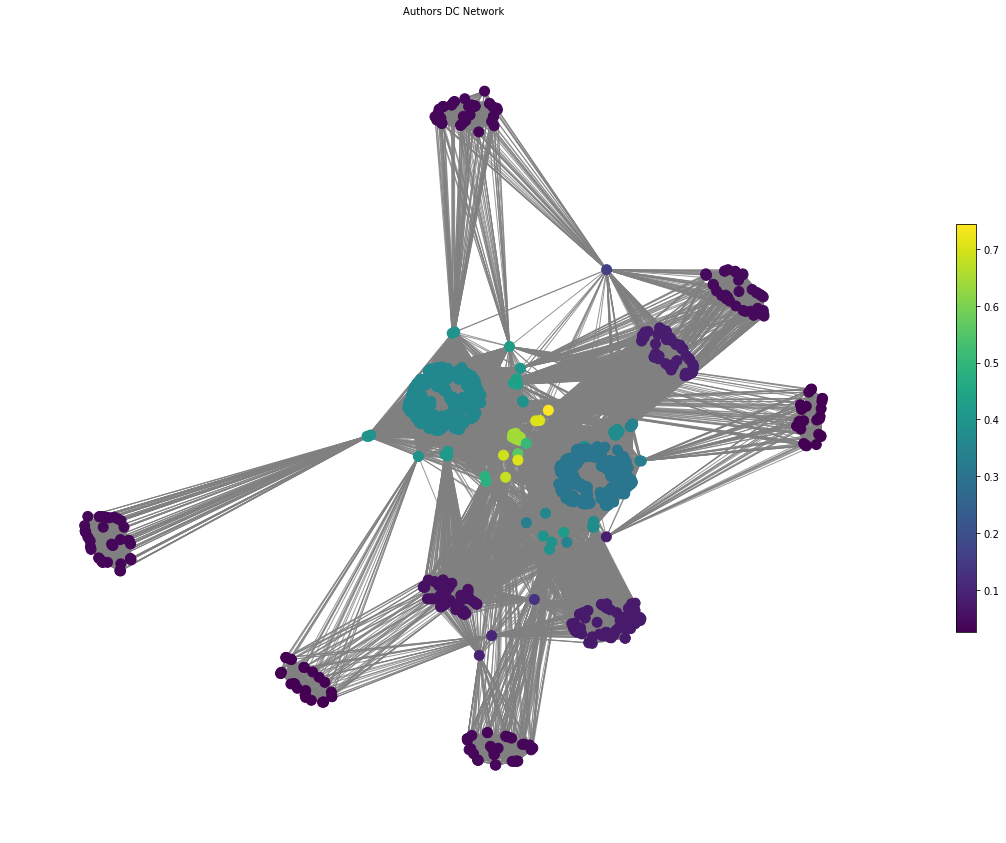

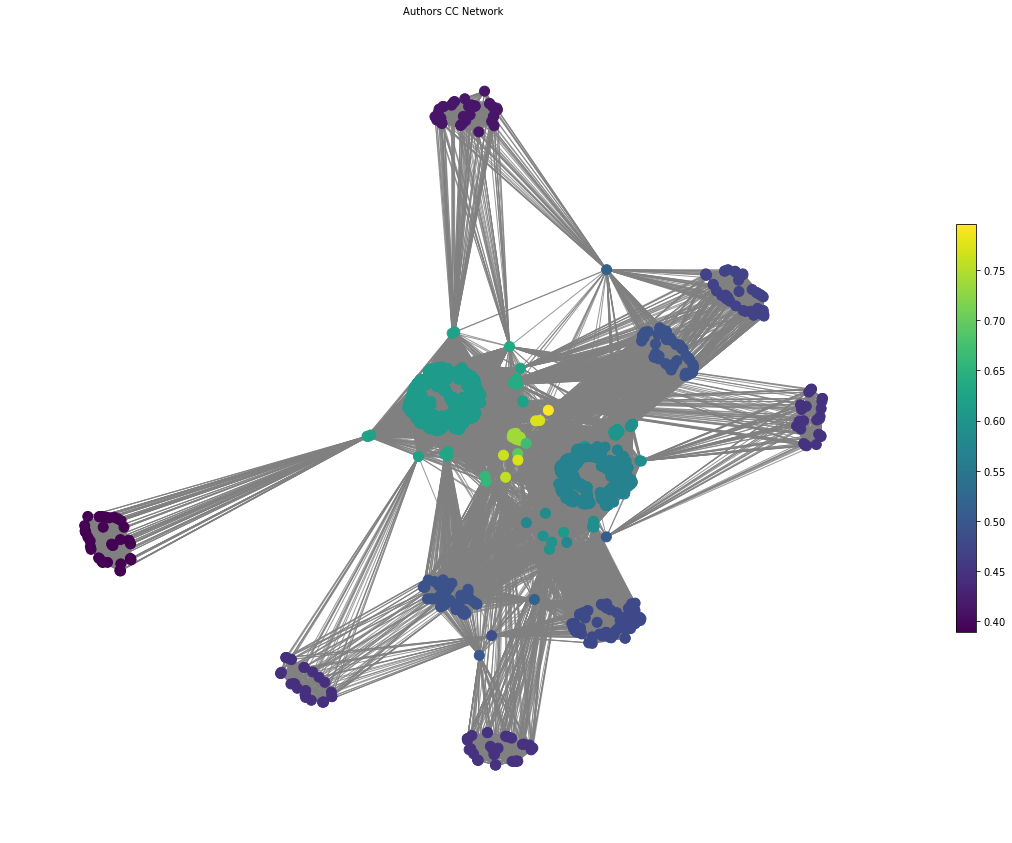

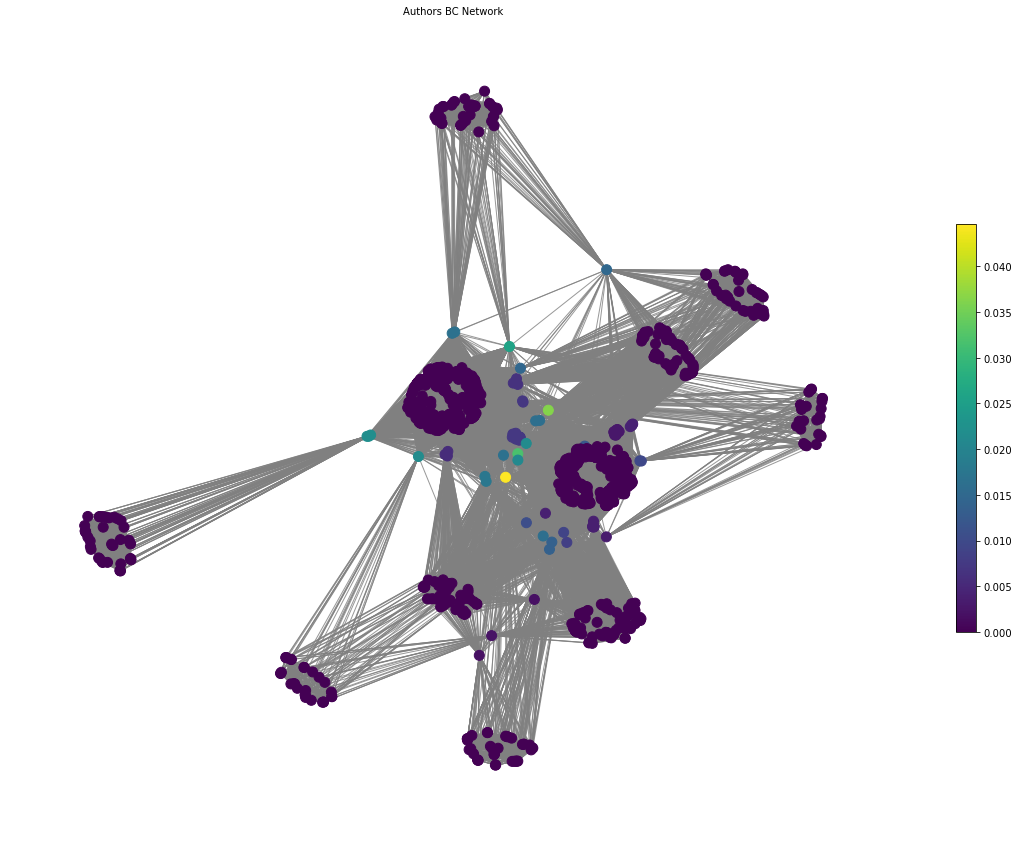

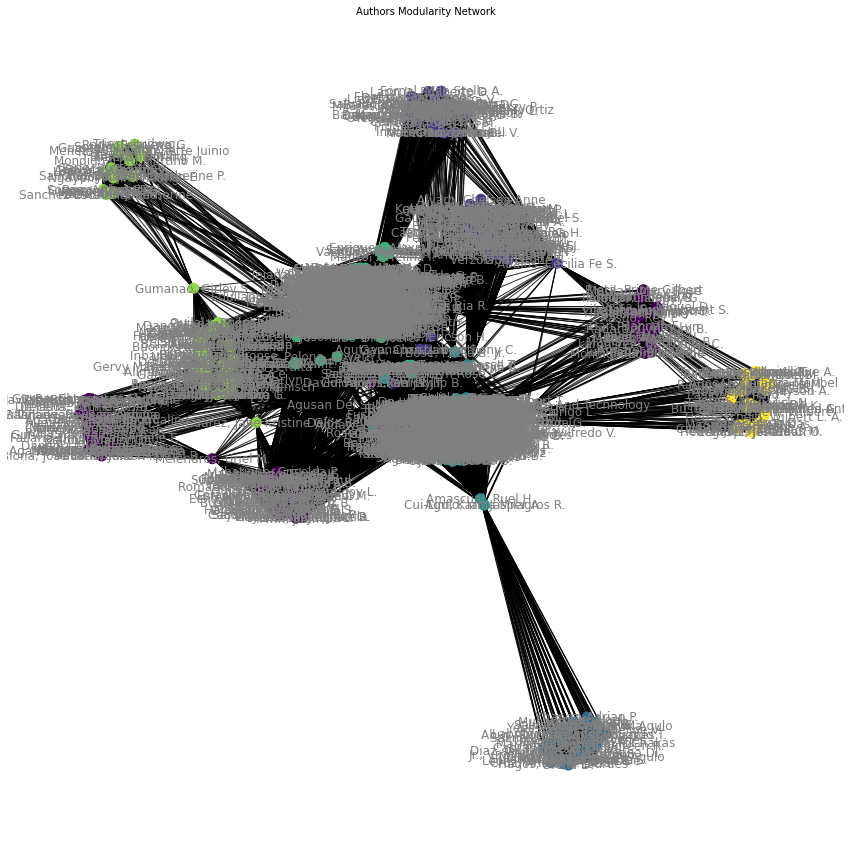

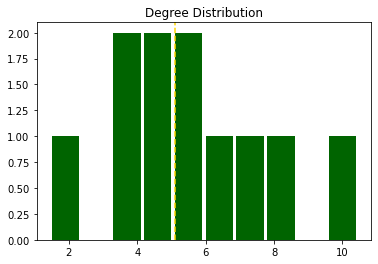

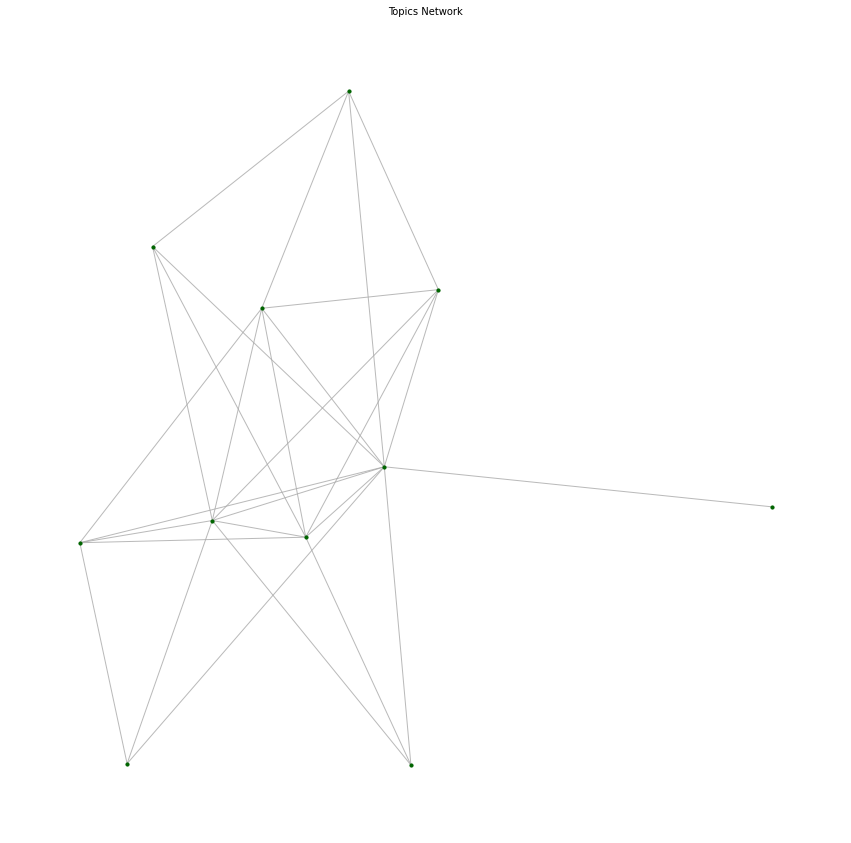

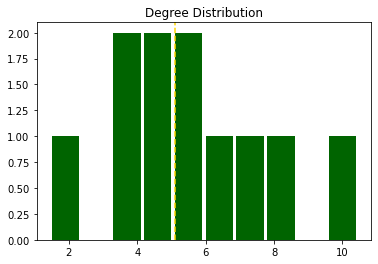

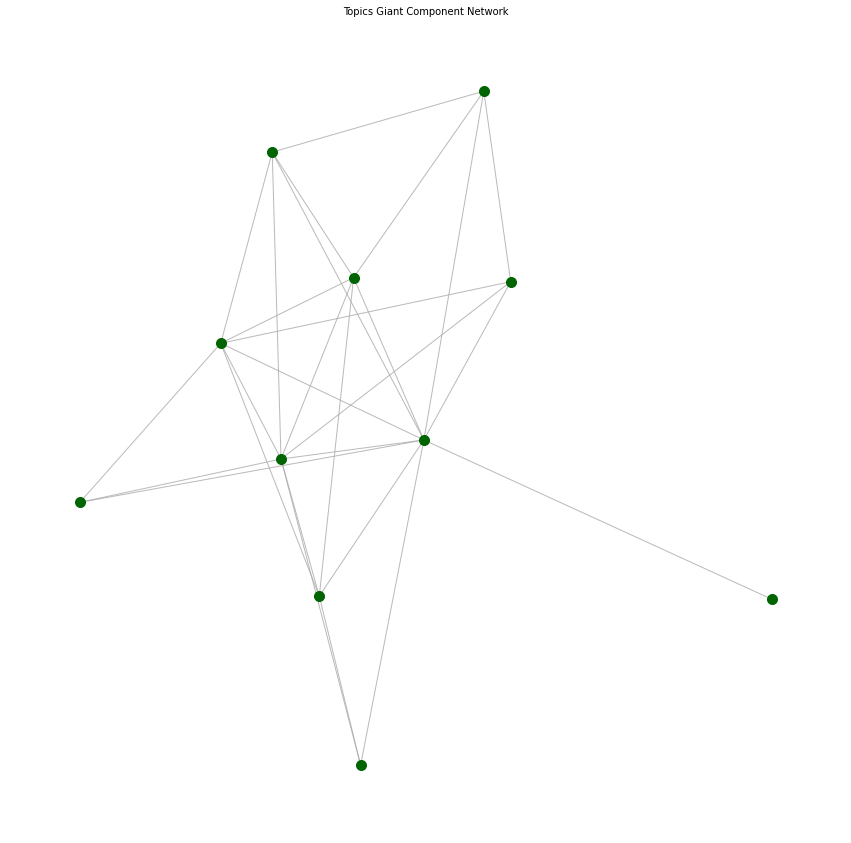

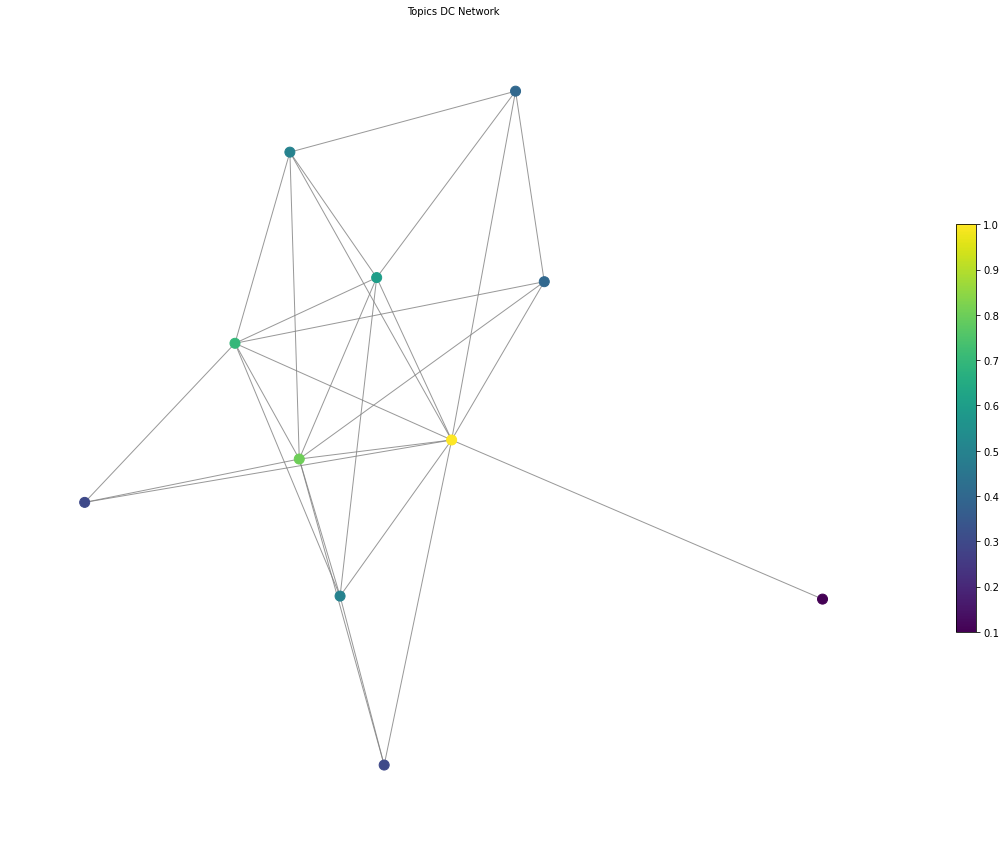

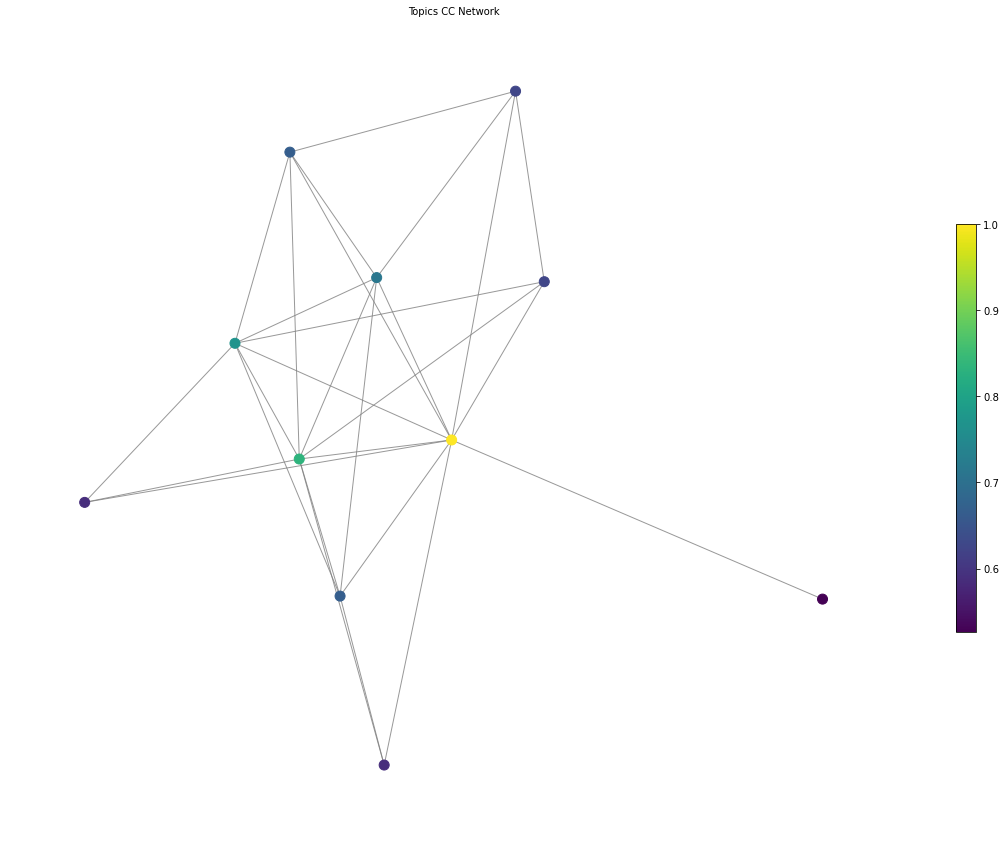

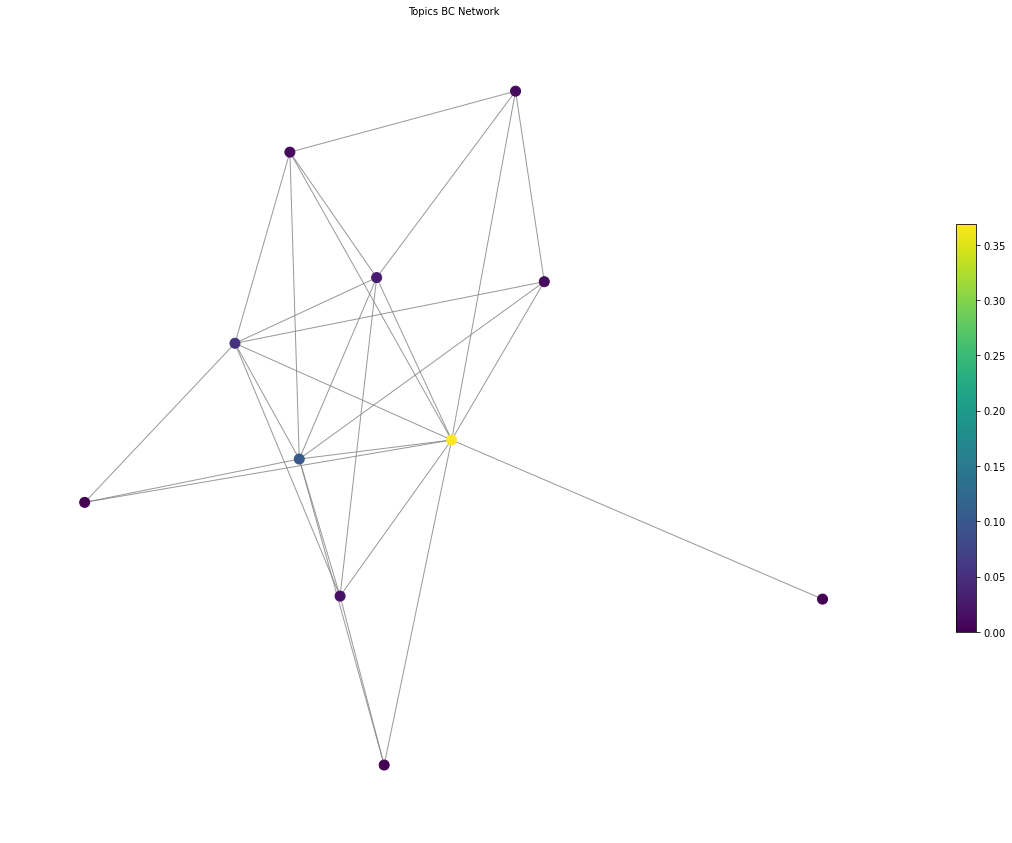

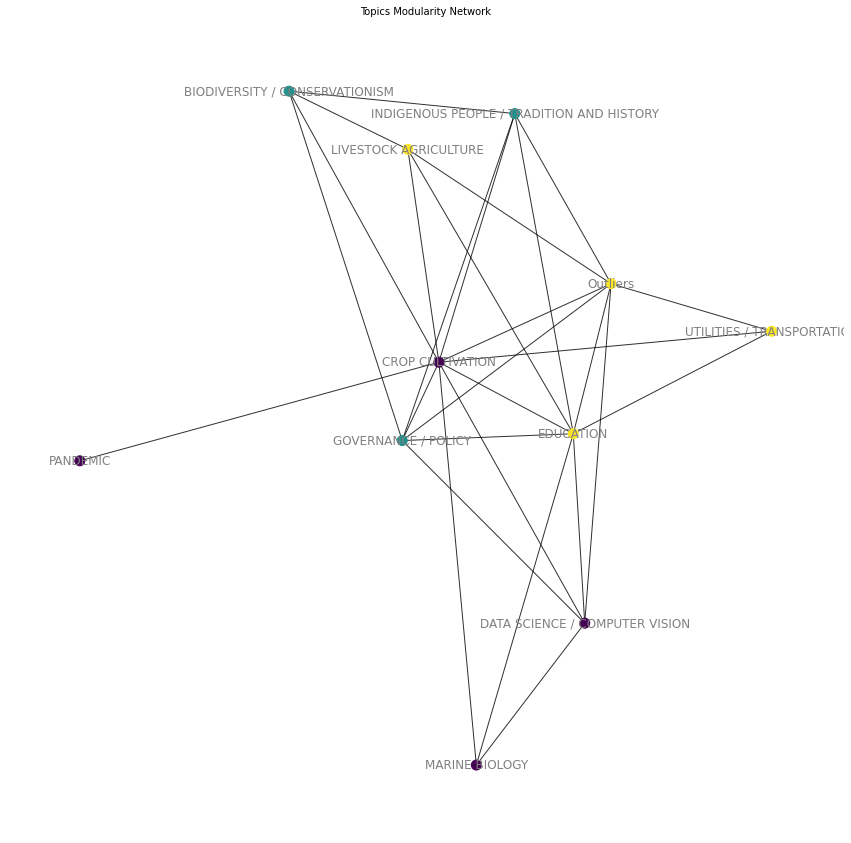

In [26]:
#dont run if not needed
#outputs and saves images of plots

bipart_network_plots(A, school='Authors')
bipart_network_plots(T, school='Topics')